In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#block warnings
import warnings
warnings.filterwarnings('ignore')

In [55]:
energy_data = pd.read_csv('global-data-on-sustainable-energy (1).csv')

# 1. Data overview and cleaning


In [56]:
energy_data.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [57]:
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (TW

In [58]:
energy_data['Entity'].value_counts()

Entity
Afghanistan      21
Oman             21
Netherlands      21
New Caledonia    21
New Zealand      21
                 ..
Zimbabwe         21
Serbia           14
Montenegro       14
South Sudan       8
French Guiana     1
Name: count, Length: 176, dtype: int64

Drop out Serbia, Montenegro, South Sudan and French Guiana out of our dataset since they don't contain data for the whole 2000-2020 period.


In [59]:
index_drop = energy_data[energy_data['Entity'].isin(['Serbia','Montenegro','South Sudan','French Guiana'])].index
energy_data = energy_data.drop(index_drop)

A barplot of the amount of missing values in each column to decide if there are columns that we need to exclude from our dataset


In [60]:
NA_values = energy_data.isna().sum()
NA_values


Entity                                                                 0
Year                                                                   0
Access to electricity (% of population)                                9
Access to clean fuels for cooking                                    168
Renewable-electricity-generating-capacity-per-capita                 903
Financial flows to developing countries (US $)                      2058
Renewable energy share in the total final energy consumption (%)     191
Electricity from fossil fuels (TWh)                                   21
Electricity from nuclear (TWh)                                       126
Electricity from renewables (TWh)                                     21
Low-carbon electricity (% electricity)                                42
Primary energy consumption per capita (kWh/person)                     0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          199
Value_co2_emissions_kt_by_country                  

Text(0.5, 1.0, 'Missing values')

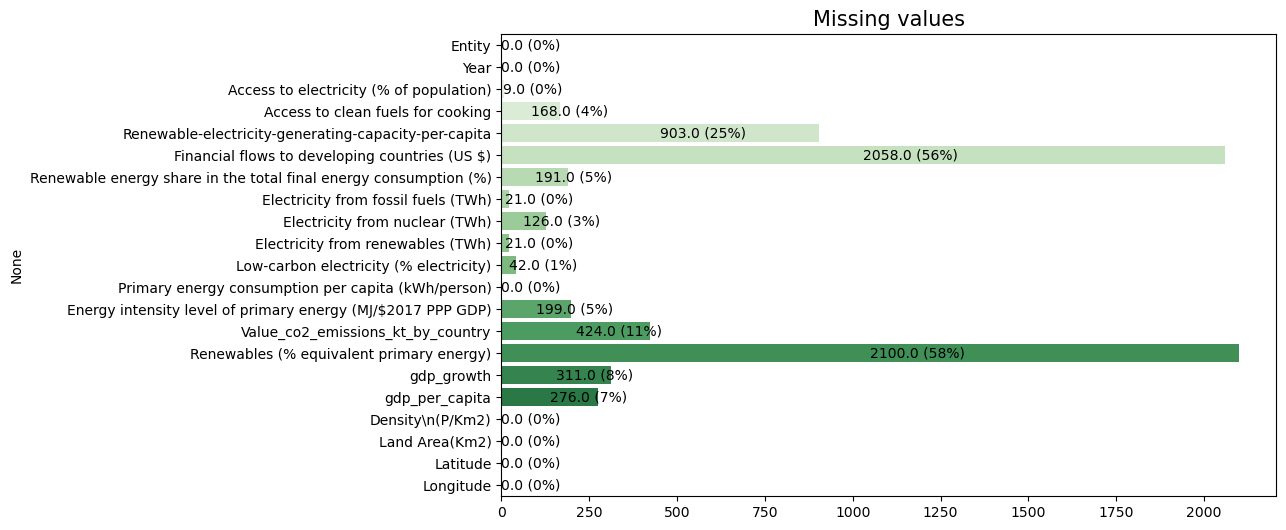

In [61]:
plt.style.use('default')
fig_NAvalues = plt.figure(figsize=(10,6))
ax = sns.barplot(x=NA_values.values,y=NA_values.index,palette='Greens')

#put values on each bar with a percentage of missing values in brackets

for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_y() + i.get_height()/2, 
            f'{i.get_width()} ({int(i.get_width()/3612*100)}%)', ha='left', va='center')
    
ax.set_title('Missing values',fontsize=15)

We can see that more than half of the data is missing in two of the features and 25% in one of them. Therefore I will not include them in our analysis. For the rest of the missing data I will try to fill it out.

In [62]:
#dropping columns with missing data
energy_data.columns
columns_to_drop = ['Renewable-electricity-generating-capacity-per-capita','Financial flows to developing countries (US $)','Renewables (% equivalent primary energy)']

energy_data_filtered = energy_data.drop(columns_to_drop,axis=1)


The next step is to handle missing values for the remaining features. In this dataset we are dealing with time series so we need to handle the values in an appropriate way. 

Since we are dealing with data about sustainable energy I assume that the changes in the consecutive years are not very big for each of the features. Because of this I think that the best way to fill in the missing values is to use a backward/forward fill which is filling the missing value with the most recent non missing value.

First let's see if there are any years where the amount of missing values is high so we can decide wheter to exclude them or not.

In [63]:
NA_values_fill = energy_data_filtered.isna().sum()

#columns with missing values
columns_with_missing  = NA_values_fill[NA_values > 0].index.tolist()

In [64]:
unique_countries = energy_data_filtered['Entity'].unique().tolist()

list_missing_sum = []
year_list = []
for column in columns_with_missing:

    
    for country in unique_countries:
        country_data = energy_data_filtered[energy_data_filtered['Entity'] == country]
        if country_data[column].isna().any():
            missing_data = country_data[country_data[column].isna()]
            
            temporary_list = missing_data['Year'].unique().tolist()
            year_list.extend(temporary_list)
    
year_series = pd.Series(year_list)
year_series.value_counts()

2020    562
2000     69
2001     67
2019     65
2002     64
2018     64
2017     63
2004     63
2003     63
2005     62
2006     61
2012     60
2007     59
2008     59
2009     59
2013     59
2016     59
2011     58
2010     58
2015     57
2014     57
Name: count, dtype: int64

Each year contains roughly the same amount of missing values apart from 2020. The reason for this might be the outbreak of Covid-19. Because of this I will exclude 2020 from our dataset. And for the rest of the years I will fill the missing values.

In [65]:
#exclude rows with 2020

i = energy_data_filtered[energy_data_filtered['Year']==2020].index
energy_data_filtered.drop(i,inplace=True)

Drop the countries with at least one feature that has all of the values missing.

In [66]:
#countries with missing values
unique_countries = energy_data_filtered['Entity'].unique().tolist()

#check which countries have at least one feature with all missing values

list_missing_sum = []
country_sum = 0
for column in columns_with_missing:

    country_sum = 0
    for country in unique_countries:
        country_data = energy_data_filtered[energy_data_filtered['Entity'] == country]
        if country_data[column].isna().all():
            country_sum += 1
            list_missing_sum.append(country)
    
unique_values = list(set(list_missing_sum))

In [67]:
#drop countries with at least one feature with all values missing

for i in unique_values:
    index_drop = energy_data_filtered[energy_data_filtered['Entity'] == i].index
    energy_data_filtered.drop(index_drop,inplace = True)

Now, after the initial cleaning of the data, let's see how many countries contain missing values.

In [68]:
#countries with missing values
unique_countries = energy_data_filtered['Entity'].unique().tolist()

#check how many countries have missing values
list_missing_sum = []
country_sum = 0
for column in columns_with_missing:

    country_sum = 0
    for country in unique_countries:
        country_data = energy_data_filtered[energy_data_filtered['Entity'] == country]
        if country_data[column].isna().any():
            country_sum += 1
    
    list_missing_sum.append(country_sum)
    
country_missing_series = pd.Series(list_missing_sum,columns_with_missing)    
country_missing_series

Access to electricity (% of population)                             2
Access to clean fuels for cooking                                   0
Renewable energy share in the total final energy consumption (%)    0
Electricity from fossil fuels (TWh)                                 0
Electricity from nuclear (TWh)                                      0
Electricity from renewables (TWh)                                   0
Low-carbon electricity (% electricity)                              0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         1
Value_co2_emissions_kt_by_country                                   0
gdp_growth                                                          8
gdp_per_capita                                                      5
dtype: int64

Let's handle the missing values of each feature separately. I will use plots to see what is the best way to fill the missing values.

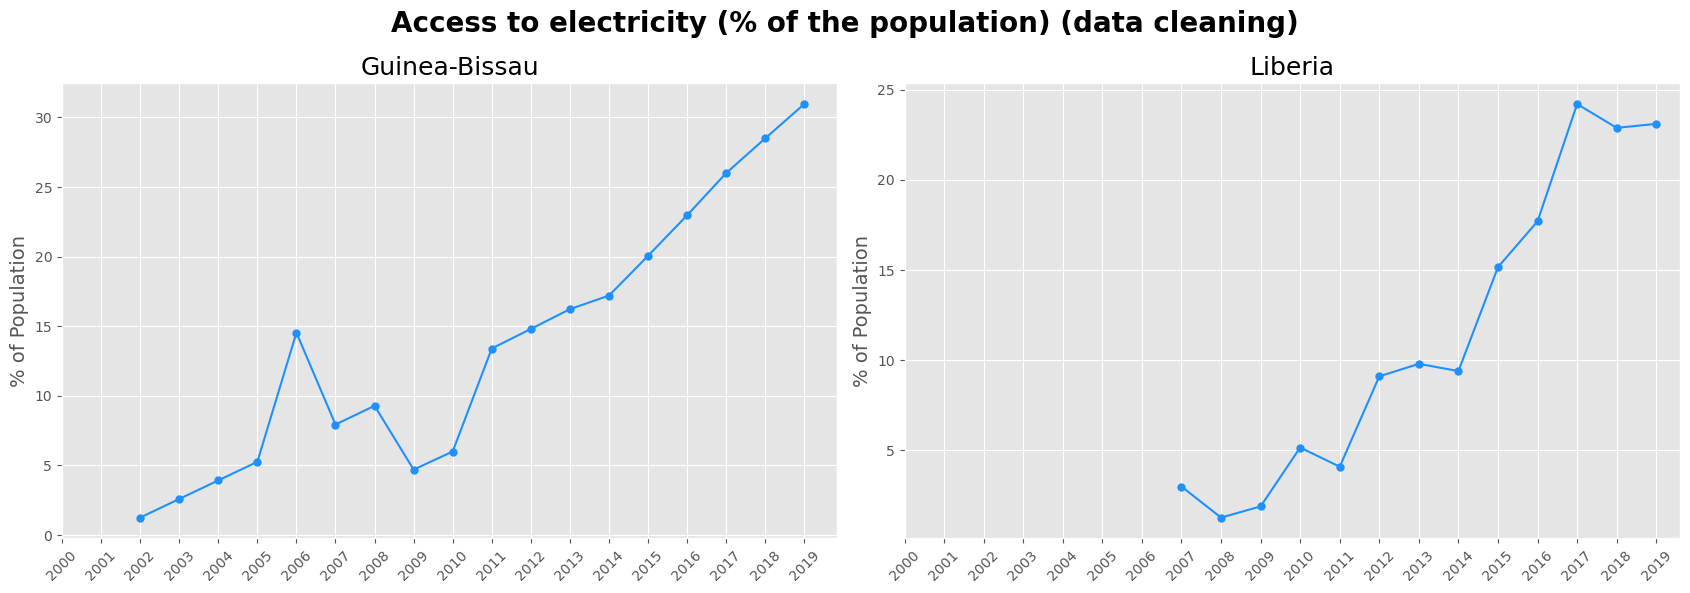

In [69]:
#first set of plots
plt.style.use('ggplot')
#first feature (Access to electricity (% of population))
fig, ax = plt.subplots(1,2,figsize=(17,6))
years=list(range(2000, 2020))


#first plot
guinea_y = energy_data_filtered[energy_data_filtered['Entity'] == 'Guinea-Bissau']['Access to electricity (% of population)'].to_list()

ax[0].plot(years,guinea_y,color='dodgerblue', linewidth=1.5, linestyle='-', marker='o', markersize=5)
ax[0].set_title('Guinea-Bissau',fontsize=18)
ax[0].set_xticks(years)
ax[0].set_xticklabels(list(range(2000, 2020)), rotation=45)
ax[0].set_ylabel('% of Population', fontsize=14)


#second plot
liberia_y = energy_data_filtered[energy_data_filtered['Entity'] == 'Liberia']['Access to electricity (% of population)'].to_list()

ax[1].plot(years,liberia_y,color='dodgerblue', linewidth=1.5, linestyle='-', marker='o', markersize=5)
ax[1].set_title('Liberia',fontsize=18)
ax[1].set_xticks(years)
ax[1].set_xticklabels(years, rotation = 45)
ax[1].set_ylabel('% of Population', fontsize=14)

fig.suptitle('Access to electricity (% of the population) (data cleaning)', fontsize=20,fontweight='bold')
plt.tight_layout()
plt.show()

For the first feature we can see a clear trend for both of the countries with missing values. Hence, I think that the backward fill is reasonable in this situation since there is only a handful of missing values which are already close to 0 so they most likely don't vary much.

In [70]:
#backward fill for liberia
energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Liberia', 'Access to electricity (% of population)'] = energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Liberia', 'Access to electricity (% of population)'].bfill()

#backward fill for guinea-bissau
energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Guinea-Bissau', 'Access to electricity (% of population)'] = energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Guinea-Bissau', 'Access to electricity (% of population)'].bfill()

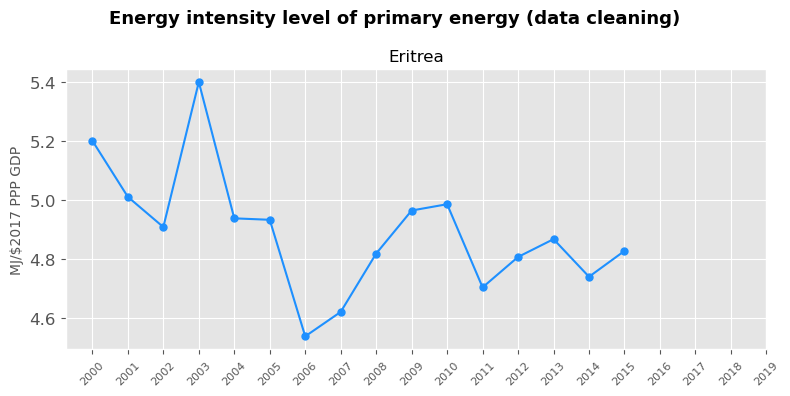

In [71]:
plt.style.use('ggplot')
#second feature (Energy intensity level of primary energy)

fig, ax = plt.subplots(1,1,figsize = (8,4))
years = list(range(2000,2020))

country_to_plot = energy_data_filtered[energy_data_filtered['Entity']=='Eritrea']['Energy intensity level of primary energy (MJ/$2017 PPP GDP)']

ax.plot(years, country_to_plot, color='dodgerblue', linewidth=1.5, linestyle='-', marker='o', markersize=5)

ax.set_title('Eritrea',fontsize=12)
ax.set_ylabel('MJ/$2017 PPP GDP',fontsize=10)

ax.set_xticks(years)
ax.set_xticklabels(list(range(2000, 2020)), rotation=45,fontsize=8)
ax.tick_params(axis='y', labelsize=12)

fig.suptitle('Energy intensity level of primary energy (data cleaning)', fontsize=13,fontweight='bold')
plt.tight_layout()
plt.show()

We can see that since 2010 values vary only slightly. They stay around 4.8 mark so I will use forward fill and use the value from 2015 to fill the rest of the years since it's around the average value of the last 5 years.

In [72]:
#forward fill for Eritrea

energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Eritrea', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'] = energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Eritrea', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'].ffill() 

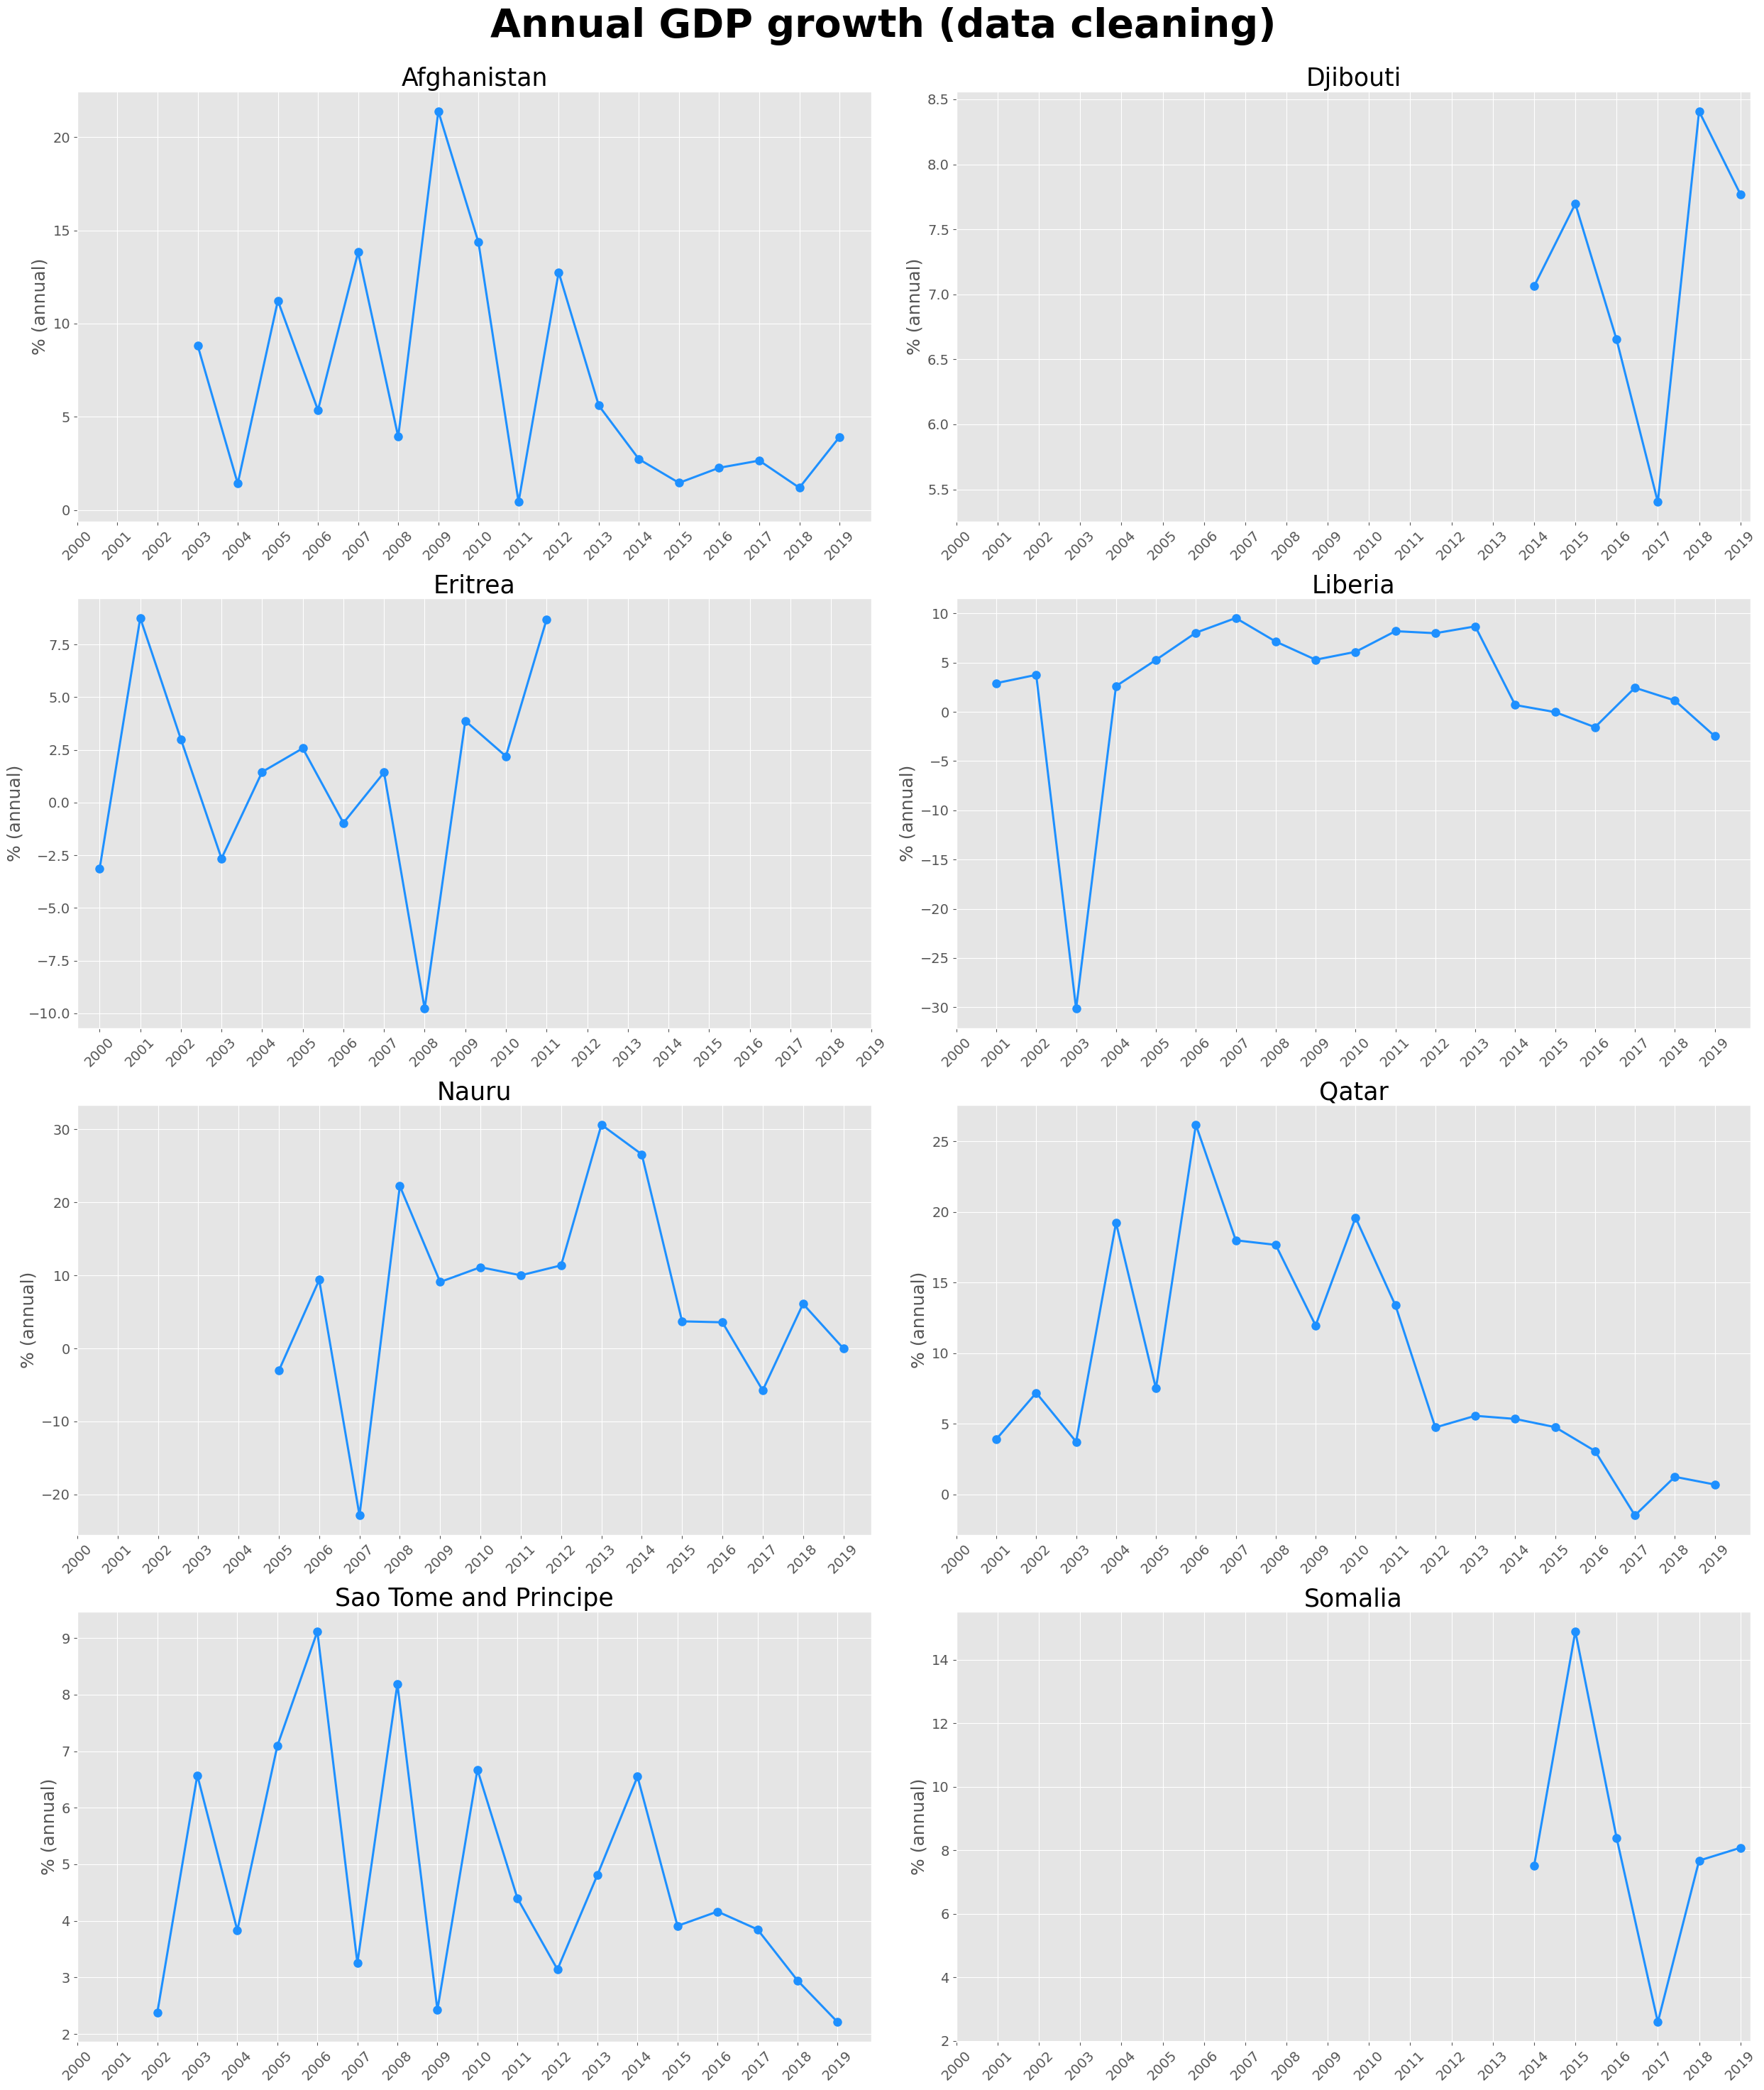

In [73]:
#third feature (gdp_growth)

plt.style.use('ggplot')

fig, ax = plt.subplots(4,2,figsize = (25,30))
years = list(range(2000,2020))

countries_to_plot = energy_data_filtered[energy_data_filtered['gdp_growth'].isna()]['Entity'].unique().tolist()
ax = ax.flatten()

for i in range(len(countries_to_plot)):
    country = energy_data_filtered[energy_data_filtered['Entity']==countries_to_plot[i]]['gdp_growth']
    ax[i].plot(years,country,color='dodgerblue', linewidth=2.2, linestyle='-', marker='o', markersize=8)
    
    ax[i].set_title(countries_to_plot[i],fontsize=25)
    ax[i].set_xticks(years)
    ax[i].set_xticklabels(years,rotation=45,fontsize=14)
    ax[i].set_ylabel('% (annual)',fontsize=18)    
    ax[i].tick_params(axis='y',labelsize=14)

fig.suptitle('Annual GDP growth (data cleaning)', fontsize=40,fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()



For Djibouti and Somalia there are too many missing values and the rest of the values do not show any trend so I will exclude those countries as well.

In [74]:
index = energy_data_filtered[energy_data_filtered['Entity'].isin(['Djibouti','Somalia'])].index
energy_data_filtered.drop(index, inplace = True)

For Liberia and Qatar there is only one missing value and nearest values following the missing values do not vary much so I will use backward fill in this situation.

In [75]:
#backward fill for liberia,qatar
energy_data_filtered.loc[energy_data_filtered['Entity'].isin(['Qatar','Liberia']), 'gdp_growth'] = energy_data_filtered.loc[energy_data_filtered['Entity'].isin(['Qatar','Liberia']), 'gdp_growth'].bfill()

For the 4 remaining countries values vary around a certain level so I think the best way to fill the missing values is to take the average of the rest of the values for each country.


In [76]:
#mean value for each country

countries_to_mean = energy_data_filtered[energy_data_filtered['gdp_growth'].isna()]['Entity'].unique().tolist()

for i in range(len(countries_to_mean)):
    mean = energy_data_filtered[energy_data_filtered['Entity'] == countries_to_mean[i]]['gdp_growth'].mean()
    energy_data_filtered.loc[energy_data_filtered['Entity']==countries_to_mean[i], 'gdp_growth'] = energy_data_filtered[energy_data_filtered['Entity']==countries_to_mean[i]]['gdp_growth'].fillna(mean)
    

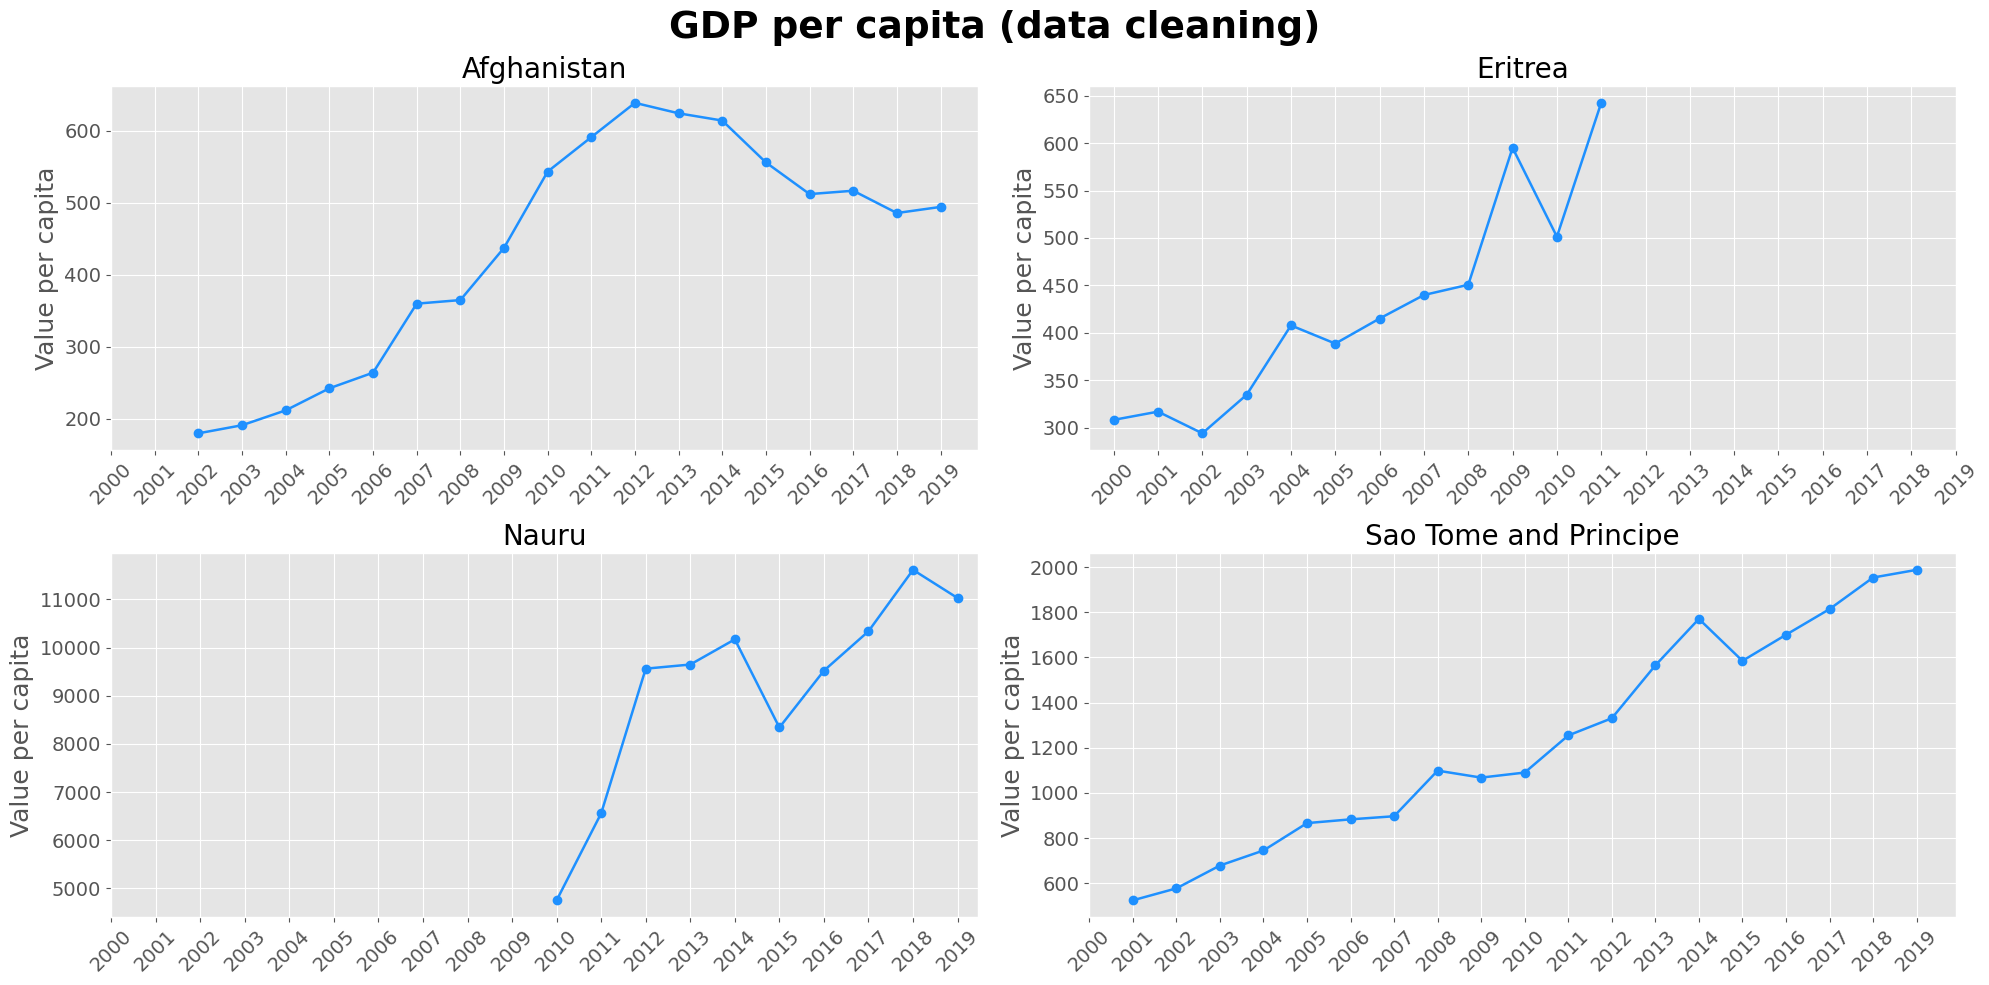

In [77]:
#fourth feature (gdp_per_capita)

plt.style.use('ggplot')

fig, ax = plt.subplots(2,2,figsize=(20,10))

countries_to_plot = energy_data_filtered[energy_data_filtered['gdp_per_capita'].isna()]['Entity'].unique().tolist()
years = list(range(2000,2020))
ax = ax.flatten()

for i in range(len(countries_to_plot)):
    country = energy_data_filtered[energy_data_filtered['Entity']==countries_to_plot[i]]['gdp_per_capita']
    ax[i].plot(years,country,color='dodgerblue',linewidth = 1.8, marker = 'o')
    ax[i].set_title(countries_to_plot[i],fontsize=20)
    ax[i].set_xticks(years)
    ax[i].set_xticklabels(years,rotation=45,fontsize=14)
    ax[i].set_ylabel('Value per capita',fontsize=18)    
    ax[i].tick_params(axis='y',labelsize=14)
    

fig.suptitle('GDP per capita (data cleaning)',fontsize=27,fontweight = 'bold')    
plt.tight_layout()
plt.show()



For Afghanistan and Sao Tome and Principe I will use a backward fill since there is only a couple of values missing and we can see a linear trend. For Nauru and Eritrea there is too many missing values so I will exclude those countries.

In [78]:
#backward fill for Afghanistan and Sao Tome and Principe

energy_data_filtered.loc[energy_data_filtered['Entity'].isin(['Afghanistan','Sao Tome and Principe']),'gdp_per_capita'] = energy_data_filtered.loc[energy_data_filtered['Entity'].isin(['Afghanistan','Sao Tome and Principe']),'gdp_per_capita'].bfill()


In [79]:
#exclude Eritrea and Nauru
index = energy_data_filtered[energy_data_filtered['Entity'].isin(['Eritrea','Nauru'])]['gdp_per_capita'].index
energy_data_filtered.drop(index, inplace = True)

Check if there are any missing values after cleaning the data.

In [80]:
energy_data_filtered.isna().sum()

Entity                                                              0
Year                                                                0
Access to electricity (% of population)                             0
Access to clean fuels for cooking                                   0
Renewable energy share in the total final energy consumption (%)    0
Electricity from fossil fuels (TWh)                                 0
Electricity from nuclear (TWh)                                      0
Electricity from renewables (TWh)                                   0
Low-carbon electricity (% electricity)                              0
Primary energy consumption per capita (kWh/person)                  0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0
Value_co2_emissions_kt_by_country                                   0
gdp_growth                                                          0
gdp_per_capita                                                      0
Density\n(P/Km2)    

Check for duplicates

In [81]:
energy_data_filtered.duplicated().sum()

0

Since there are no more missing values left, we can begin the EDA part of the project.

Assign a continent name next to each country in a new column.

In [82]:
iso_countries = pd.read_csv('wikipedia-iso-country-codes.csv')
iso_countries.rename(columns={'English short name lower case':'Entity'},inplace=True)
iso_countries.drop(['Alpha-3 code','Numeric code','ISO 3166-2'],axis=1,inplace=True)

iso_countries.head()

energy_data_filtered = pd.merge(energy_data_filtered, iso_countries, how='left', on='Entity')

In [83]:
country_to_continent = {
    'AF': 'Asia', 'AL': 'Europe', 'DZ': 'Africa', 'AS': 'Oceania', 'AD': 'Europe', 'AO': 'Africa',
    'AG': 'North America', 'AR': 'South America', 'AM': 'Asia', 'AU': 'Oceania', 'AT': 'Europe',
    'AZ': 'Asia', 'BS': 'North America', 'BH': 'Asia', 'BD': 'Asia', 'BB': 'North America',
    'BY': 'Europe', 'BE': 'Europe', 'BZ': 'North America', 'BJ': 'Africa', 'BT': 'Asia', 'BO': 'South America',
    'BA': 'Europe', 'BW': 'Africa', 'BR': 'South America', 'BN': 'Asia', 'BG': 'Europe', 'BF': 'Africa',
    'BI': 'Africa', 'KH': 'Asia', 'CM': 'Africa', 'CA': 'North America', 'CV': 'Africa', 'CF': 'Africa',
    'TD': 'Africa', 'CL': 'South America', 'CN': 'Asia', 'CO': 'South America', 'KM': 'Africa', 'CG': 'Africa',
    'CR': 'North America', 'HR': 'Europe', 'CU': 'North America', 'CY': 'Asia', 'CZ': 'Europe', 'DK': 'Europe',
    'DJ': 'Africa', 'DM': 'North America', 'DO': 'North America', 'EC': 'South America', 'EG': 'Africa',
    'SV': 'North America', 'GQ': 'Africa', 'ER': 'Africa', 'EE': 'Europe', 'ET': 'Africa', 'FJ': 'Oceania',
    'FI': 'Europe', 'FR': 'Europe', 'GA': 'Africa', 'GM': 'Africa', 'GE': 'Asia', 'DE': 'Europe', 'GH': 'Africa',
    'GR': 'Europe', 'GD': 'North America', 'GT': 'North America', 'GN': 'Africa', 'GW': 'Africa', 'GY': 'South America',
    'HT': 'North America', 'HN': 'North America', 'HU': 'Europe', 'IS': 'Europe', 'IN': 'Asia', 'ID': 'Asia',
    'IR': 'Asia', 'IQ': 'Asia', 'IE': 'Europe', 'IL': 'Asia', 'IT': 'Europe', 'JM': 'North America', 'JP': 'Asia',
    'JO': 'Asia', 'KZ': 'Asia', 'KE': 'Africa', 'KI': 'Oceania', 'KR': 'Asia', 'KW': 'Asia', 'KG': 'Asia',
    'LA': 'Asia', 'LV': 'Europe', 'LB': 'Asia', 'LS': 'Africa', 'LR': 'Africa', 'LY': 'Africa', 'LT': 'Europe',
    'LU': 'Europe', 'MG': 'Africa', 'MW': 'Africa', 'MY': 'Asia', 'MV': 'Asia', 'ML': 'Africa', 'MT': 'Europe',
    'MH': 'Oceania', 'MR': 'Africa', 'MU': 'Africa', 'MX': 'North America', 'FM': 'Oceania', 'MD': 'Europe',
    'MC': 'Europe', 'MN': 'Asia', 'ME': 'Europe', 'MA': 'Africa', 'MZ': 'Africa', 'MM': 'Asia', 'NA': 'Africa',
    'NR': 'Oceania', 'NP': 'Asia', 'NL': 'Europe', 'NZ': 'Oceania', 'NI': 'North America', 'NE': 'Africa',
    'NG': 'Africa', 'NO': 'Europe', 'OM': 'Asia', 'PK': 'Asia', 'PW': 'Oceania', 'PA': 'North America', 
    'PG': 'Oceania', 'PY': 'South America', 'PE': 'South America', 'PH': 'Asia', 'PL': 'Europe', 'PT': 'Europe',
    'QA': 'Asia', 'RO': 'Europe', 'RU': 'Europe', 'RW': 'Africa', 'WS': 'Oceania', 'SA': 'Asia', 'SN': 'Africa',
    'RS': 'Europe', 'SC': 'Africa', 'SL': 'Africa', 'SG': 'Asia', 'SK': 'Europe', 'SI': 'Europe', 'SB': 'Oceania',
    'SO': 'Africa', 'ZA': 'Africa', 'ES': 'Europe', 'LK': 'Asia', 'SD': 'Africa', 'SR': 'South America',
    'SE': 'Europe', 'CH': 'Europe', 'SY': 'Asia', 'TW': 'Asia', 'TZ': 'Africa', 'TH': 'Asia', 'TG': 'Africa',
    'TO': 'Oceania', 'TT': 'North America', 'TN': 'Africa', 'TR': 'Asia', 'TM': 'Asia', 'UG': 'Africa',
    'UA': 'Europe', 'AE': 'Asia', 'GB': 'Europe', 'US': 'North America', 'UY': 'South America', 'UZ': 'Asia',
    'VU': 'Oceania', 'VE': 'South America', 'VN': 'Asia', 'YE': 'Asia', 'ZM': 'Africa', 'ZW': 'Africa'
}

def get_continent_from_country_code(country_code):
    return country_to_continent.get(country_code, "Unknown")

energy_data_filtered['Continent'] = energy_data_filtered['Alpha-2 code'].apply(get_continent_from_country_code)

In [84]:
energy_data_filtered[energy_data_filtered['Continent'] == 'Unknown']['Entity'].unique()

array(['Eswatini', 'Namibia', 'North Macedonia', 'Sao Tome and Principe',
       'Tajikistan'], dtype=object)

In [85]:
energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Namibia','Continent'] = 'Africa'
energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Eswatini','Continent'] = 'Africa'
energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Sao Tome and Principe','Continent'] = 'Africa'

energy_data_filtered.loc[energy_data_filtered['Entity'] == 'North Macedonia','Continent'] = 'Europe'

energy_data_filtered.loc[energy_data_filtered['Entity'] == 'Tajikistan','Continent'] = 'Asia'

In [86]:
energy_data_filtered['Continent'].value_counts()

Continent
Africa           840
Asia             620
Europe           620
North America    380
South America    180
Oceania          180
Name: count, dtype: int64

In [87]:
energy_data_filtered['Continent'].isna().sum()

0

# 2. EDA

I want to divide this section into two parts.

The first one will be a comparison of development of sustainable energy in Poland and Western Europe countries.

The second part will concentrate on comparing energy-related measures of each continent to see the differences in sustainable energy development across the world.

## 2.1 Poland vs. Western Europe

Comparison of sustainable energy in Poland and Western Europe countries (Austria, Belgium, France, Germany, Ireland, Luxembourg ,Netherlands, Switzerland, United Kingdom) which are considered leading countries in the energy change in Europe.


In [88]:
#check if countries are in a dataframe

west_europe = ['Austria', 'Belgium', 'France', 'Germany', 'Ireland', 'Luxembourg' ,'Netherlands', 'Switzerland', 'United Kingdom']

energy_data_filtered[energy_data_filtered['Entity'].isin(west_europe)]['Entity'].unique()

array(['Austria', 'Belgium', 'France', 'Germany', 'Ireland', 'Luxembourg',
       'Netherlands', 'Switzerland', 'United Kingdom'], dtype=object)

**Low-carbon electricity comparison**

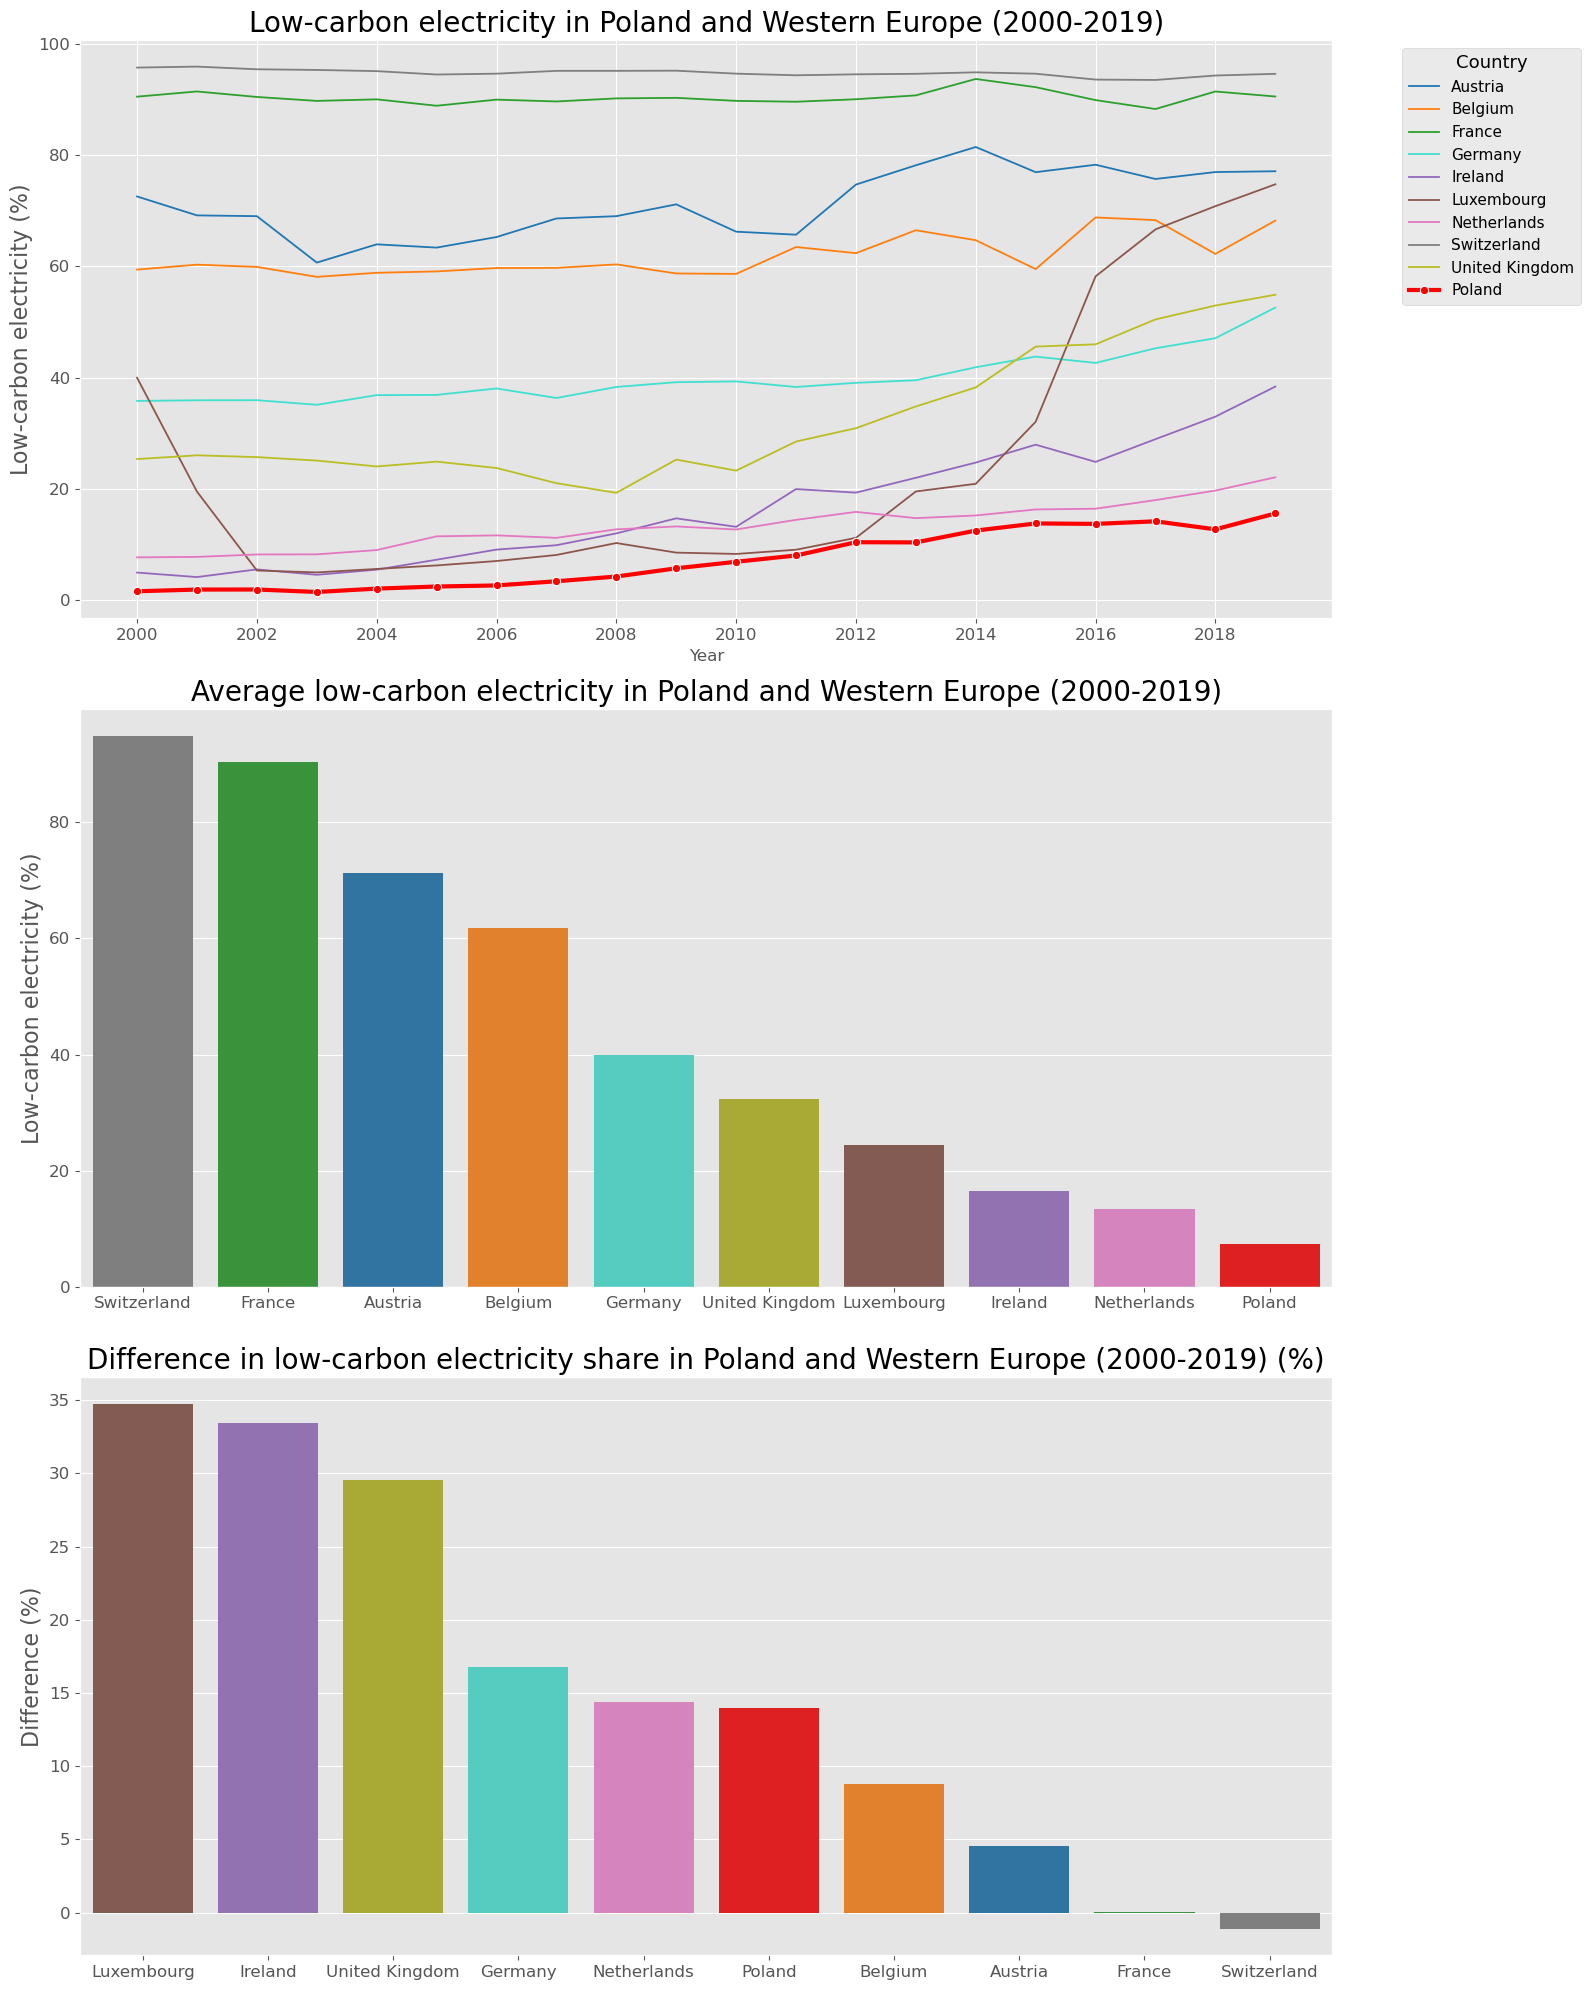

In [89]:
plt.style.use('ggplot')

countries_to_plot = west_europe + ['Poland']
plot_data = energy_data_filtered[energy_data_filtered['Entity'].isin(countries_to_plot)]
palette = sns.color_palette("tab10", len(countries_to_plot))

fig, ax =  plt.subplots(3,1,figsize=(16,20))
ax = ax.flatten()

color_mapping = dict(zip(countries_to_plot, palette))
color_mapping['Poland'] = 'red'
color_mapping['Germany'] = 'turquoise'

#first plot
sns.lineplot(data=plot_data[plot_data['Entity'] != 'Poland'], x='Year', y='Low-carbon electricity (% electricity)', hue='Entity', palette=color_mapping,
                  lw=1.3,ax=ax[0])

poland_line = plot_data[plot_data['Entity'] == 'Poland']
sns.lineplot(data=poland_line, x='Year', y='Low-carbon electricity (% electricity)',color = color_mapping['Poland'],
             marker='o', lw=3, label='Poland',ax=ax[0])

ax[0].set_title('Low-carbon electricity in Poland and Western Europe (2000-2019)', fontsize=20)
ax[0].set_ylabel('Low-carbon electricity (%)', fontsize=16)
ax[0].set_xticks(list(range(2000,2020,2)))
ax[0].legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize='13', fontsize='11')
ax[0].tick_params(labelsize=12)

#second plot
avg_low_carbon = plot_data.groupby('Entity')['Low-carbon electricity (% electricity)'].mean().reset_index()
avg_low_carbon = avg_low_carbon.sort_values(by='Low-carbon electricity (% electricity)',ascending=False)
sns.barplot(data=avg_low_carbon, x='Entity', y='Low-carbon electricity (% electricity)',hue='Entity',
            palette=[color_mapping[country] for country in avg_low_carbon['Entity']]
            , ax=ax[1])

ax[1].set_title('Average low-carbon electricity in Poland and Western Europe (2000-2019)', fontsize=20)
ax[1].set_xlabel('')
ax[1].tick_params(axis='both',labelsize=12)
ax[1].set_ylabel('Low-carbon electricity (%)', fontsize=16)

#Third plot
difference = plot_data.groupby('Entity').agg(
    first_value=('Low-carbon electricity (% electricity)', 'first'),
    last_value=('Low-carbon electricity (% electricity)', 'last')
).reset_index()

difference['Difference'] = (difference['last_value'] - difference['first_value'])
difference = difference.sort_values(by='Difference',ascending=False)

sns.barplot(difference,x='Entity',y='Difference',hue='Entity',palette=[color_mapping[country] for country in difference['Entity']],
           ax=ax[2])

ax[2].set_title('Difference in low-carbon electricity share in Poland and Western Europe (2000-2019) (%)', fontsize=20)
ax[2].set_xlabel('')
ax[2].tick_params(axis='both',labelsize=12)
ax[2].set_ylabel('Difference (%)', fontsize=16)

plt.tight_layout()
plt.show()



Poland's average low-carbon electricity share in total energy production is the lowest in comparison with Western Europe. The increase in low-carbon energy has been small - from 2% to 18% in almost 20 years.

Countries with the highest average low-carbon electricity share are Switzerland, France, Austria and Belgium. Also their green-energy share stayed on almost the same level for the whole 2000-2019 period (~95%,90%,70% and 60% respectively).

According to the last plot, since the year 2000 Luxembourg and Ireland have seen over 30% increase in low-carbon electricity share. Also United Kingdom seeing almost 30% increase. On a contrary France and Switzerland have seen a negligible decrease.

Overall, we can see that across the 2000-2019 period Poland and Western Europe have seen development and increase in low-carbon energy share and have a tendency to increase even more in the future.

**Types of energy comparison**

In [90]:
energy_data_filtered.rename(columns={'Density\\n(P/Km2)': 'Density (P/Km2)'}, inplace=True)

In [91]:
energy_data_filtered['Density (P/Km2)'] = energy_data_filtered['Density (P/Km2)'].str.replace(',', '').fillna(0).astype(int)
density_mean = energy_data_filtered[energy_data_filtered['Density (P/Km2)'] != 0]['Density (P/Km2)'].mean()
energy_data_filtered['Density (P/Km2)'] = energy_data_filtered['Density (P/Km2)'].replace(0, density_mean).astype(int)

Create new features

In [92]:
energy_data_filtered['Total electricity (TWh)'] = (energy_data_filtered['Electricity from fossil fuels (TWh)'] +
energy_data_filtered['Electricity from nuclear (TWh)'] + energy_data_filtered['Electricity from renewables (TWh)'])

energy_data_filtered['Fossil fuels (%)'] = (energy_data_filtered['Electricity from fossil fuels (TWh)']/
                                            energy_data_filtered['Total electricity (TWh)'])*100

energy_data_filtered['Nuclear (%)'] = (energy_data_filtered['Electricity from nuclear (TWh)']/
                                            energy_data_filtered['Total electricity (TWh)'])*100

energy_data_filtered['Renewables (%)'] = (energy_data_filtered['Electricity from renewables (TWh)']/
                                            energy_data_filtered['Total electricity (TWh)'])*100

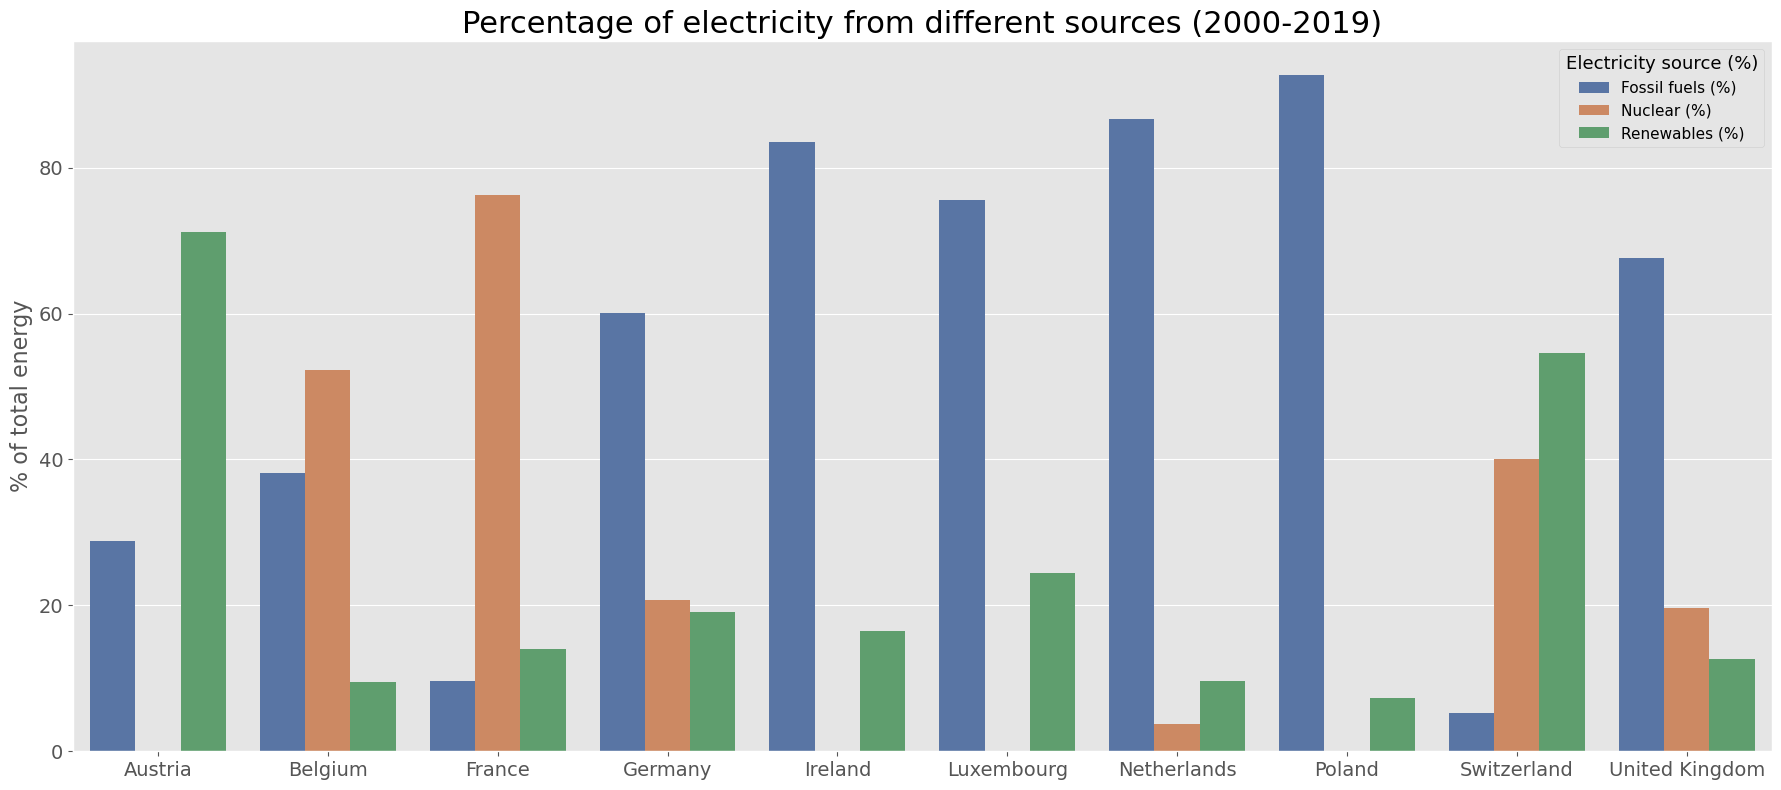

In [93]:
countries_to_plot = west_europe + ['Poland']
plot_data = energy_data_filtered[energy_data_filtered['Entity'].isin(countries_to_plot)]
columns_to_groupby = ['Entity','Fossil fuels (%)','Nuclear (%)','Renewables (%)']

country_groupby = plot_data[columns_to_groupby].groupby('Entity').mean().reset_index()
country_groupby

#melt to do a bar plot with three bars shown for each country
groupby_melted = pd.melt(country_groupby, id_vars = 'Entity',value_vars =['Fossil fuels (%)','Nuclear (%)','Renewables (%)'],var_name='Electricity (%) of total',value_name='Value')
groupby_melted

#barplot
fig, ax = plt.subplots(figsize=(18,8))

sns.barplot(data=groupby_melted, x='Entity', y='Value', hue='Electricity (%) of total',ax=ax,palette="deep")

ax.set_title('Percentage of electricity from different sources (2000-2019)',fontsize=22)
ax.set_xlabel('')
ax.set_ylabel('% of total energy',fontsize=16)
ax.tick_params(axis='both',labelsize=14)
ax.legend(title ='Electricity source (%)' ,title_fontsize='13', fontsize='11')


plt.tight_layout()

We can see that Ireland, Luxembourg, Netherlands and Poland rely mostly on fossil fuels to create energy with all of those countries not having nuclear energy altogether apart from the Netherlands.

Six out of ten countries use nuclear energy with France having the highest share.

When it comes to renewable energy, in Austria and Switzerland it accounts for over 50% of the energy produced in those countries. When it comes to other countries, in nearly all of them renewables account for less then 20% of the energy.
It looks like Western Europe still have some work to do in developing the renewable energy sector. 

**CO2 emissions per capita comparison**

In [94]:
#create new feature: population and CO2 emissions per capita (mT)
energy_data_filtered['Population'] = (energy_data_filtered['Density (P/Km2)']*energy_data_filtered['Land Area(Km2)'])
energy_data_filtered['CO2 emissions per capita (mT)'] = (energy_data_filtered['Value_co2_emissions_kt_by_country'] / energy_data_filtered['Population'])*1000

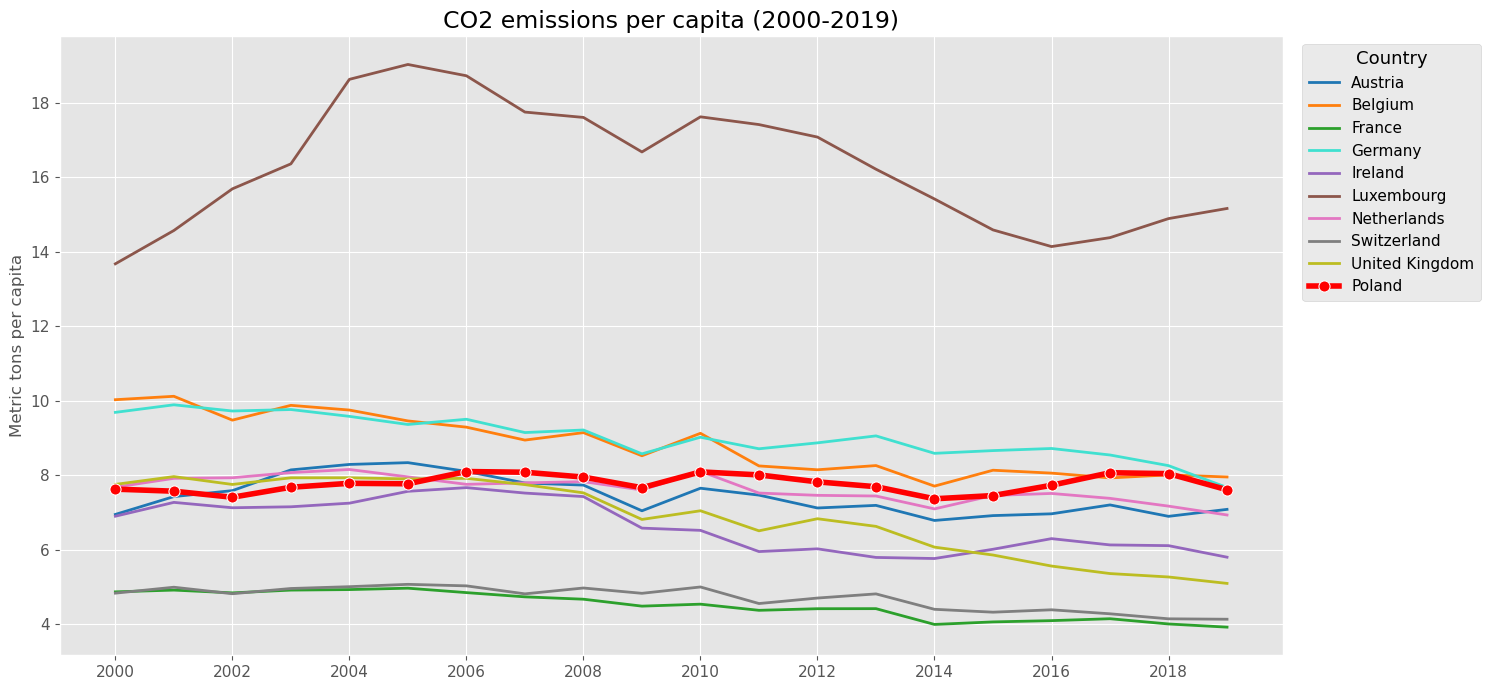

In [95]:
plt.style.use('ggplot')
countries_to_plot_new = west_europe + ['Poland']
plot_data_new = energy_data_filtered[energy_data_filtered['Entity'].isin(countries_to_plot)].copy()
palette_new = sns.color_palette("tab10", len(countries_to_plot))


color_map = dict(zip(countries_to_plot_new,palette_new))
color_map['Poland'] = 'red'
color_map['Germany'] = 'turquoise'

#plot

fig = plt.subplots(figsize=(15,7))

ax = sns.lineplot(plot_data_new[plot_data_new['Entity'] != 'Poland'], x='Year', y='CO2 emissions per capita (mT)',hue='Entity',
            palette=color_map, lw=2)

ax = sns.lineplot(plot_data_new[plot_data_new['Entity'] == 'Poland'], x='Year', y='CO2 emissions per capita (mT)',
            color=color_map['Poland'],label='Poland', lw=4,marker='o',markersize=8)

ax.set_title('CO2 emissions per capita (2000-2019)',fontsize=17)
ax.set_xlabel('')
ax.set_xticks(list(range(2000,2020,2)))
ax.set_ylabel('Metric tons per capita')
ax.tick_params(axis='both',labelsize=11)
ax.legend(title='Country', bbox_to_anchor=(1.01, 1), loc='upper left', title_fontsize='13', fontsize='11')

plt.tight_layout()
plt.show()

We can see that even though Poland has very small usage of low-carbon electricity and over 90% of its electricity comes from fossil fuels, its CO2 emissions per capita are comparable with those of the Western Europe countries. 

Countries who produce the least CO2 emissions per capita are France, Switzerland which is not surprising since fossil fuels account for less than 10% of their electricity production.

There is clear yet small downward trend for each country apart from Poland and Luxembourg which stay roughly on the same level, which means since year 2000 CO2 emissions per capita in Western Europe have been slowly decreasing.

The country with the biggest production of CO2 emissions per capita in Europe is Luxembourg.

**Renewables in total energy production vs. Renewables in total final energy consumption**

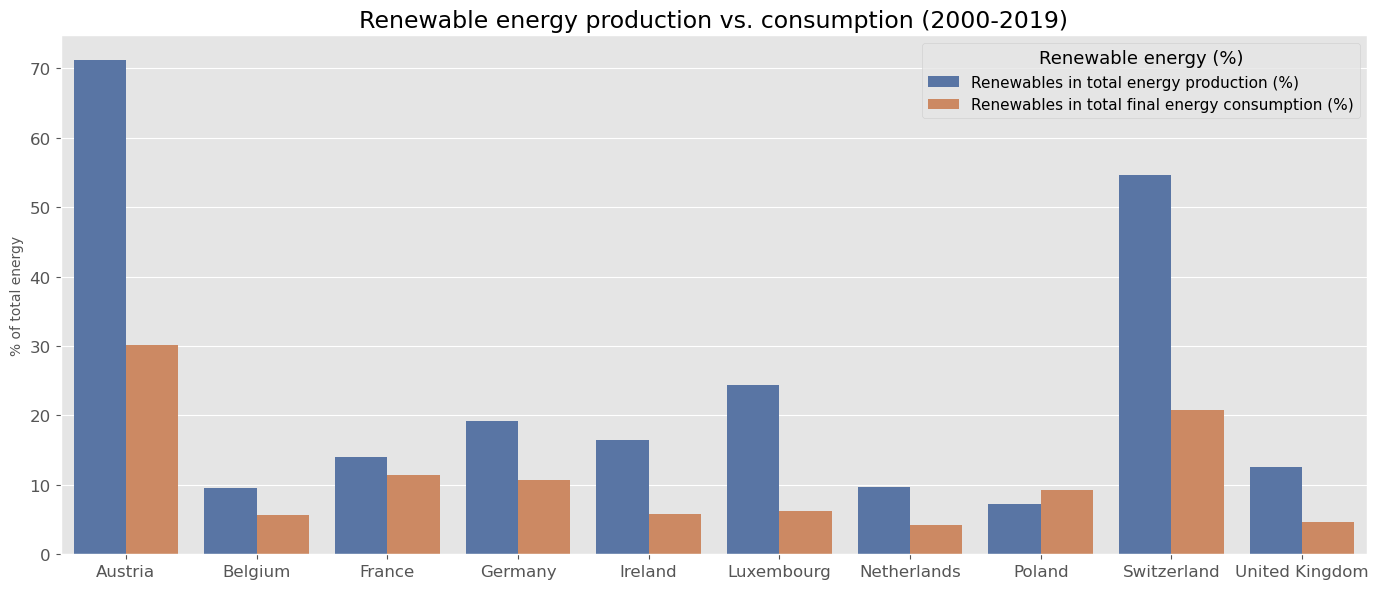

In [96]:
countries_to_plot = west_europe + ['Poland']
plot_data = energy_data_filtered[energy_data_filtered['Entity'].isin(countries_to_plot)]

features_to_groupby = ['Entity','Renewables (%)','Renewable energy share in the total final energy consumption (%)']

country_groupby = plot_data[features_to_groupby].groupby('Entity').mean().reset_index()

renewable_melted = pd.melt(country_groupby,id_vars = 'Entity',value_vars=features_to_groupby,var_name = 'Renewable energy share',value_name='Value' )
renewable_melted

renewable_melted['Renewable energy share'] = renewable_melted['Renewable energy share'].replace({
    'Renewables (%)': 'Renewables in total energy production (%)',
    'Renewable energy share in the total final energy consumption (%)': 'Renewables in total final energy consumption (%)'
})

#plot
fig, ax = plt.subplots(figsize=(14,6))

sns.barplot(renewable_melted, x='Entity', y='Value', hue='Renewable energy share',ax=ax,palette="deep")

ax.set_title('Renewable energy production vs. consumption (2000-2019)',fontsize=17)
ax.set_xlabel('')
ax.set_ylabel('% of total energy',fontsize=10)
ax.tick_params(axis='both',labelsize=12)
ax.legend(title ='Renewable energy (%)' ,title_fontsize='13', fontsize='11')



plt.tight_layout()
plt.show()

We can see some notable disparity between energy production and consumption from renewables in a few countries. 

Austria and Switzerland have the highest percentage of renewable energy production out of all countries, yet the total final energy consumption from renewables is a lot lower which might mean that these countries export the energy or they have a problem in delivering it to the end user.

Poland's percentage of renewable energy production is the lowest compared to the Western Europe countries, yet its total final consumption is higher than in some countries which might mean that Poland does a good job in utilizing renewable energy production in domestic consumption.

Big difference in renewables production and consumption in countries such as Austria, Switzerland, Luxembourg, Ireland might indicate that they are exporters of renewable energy to other countries.

**Energy intensity level comparison**

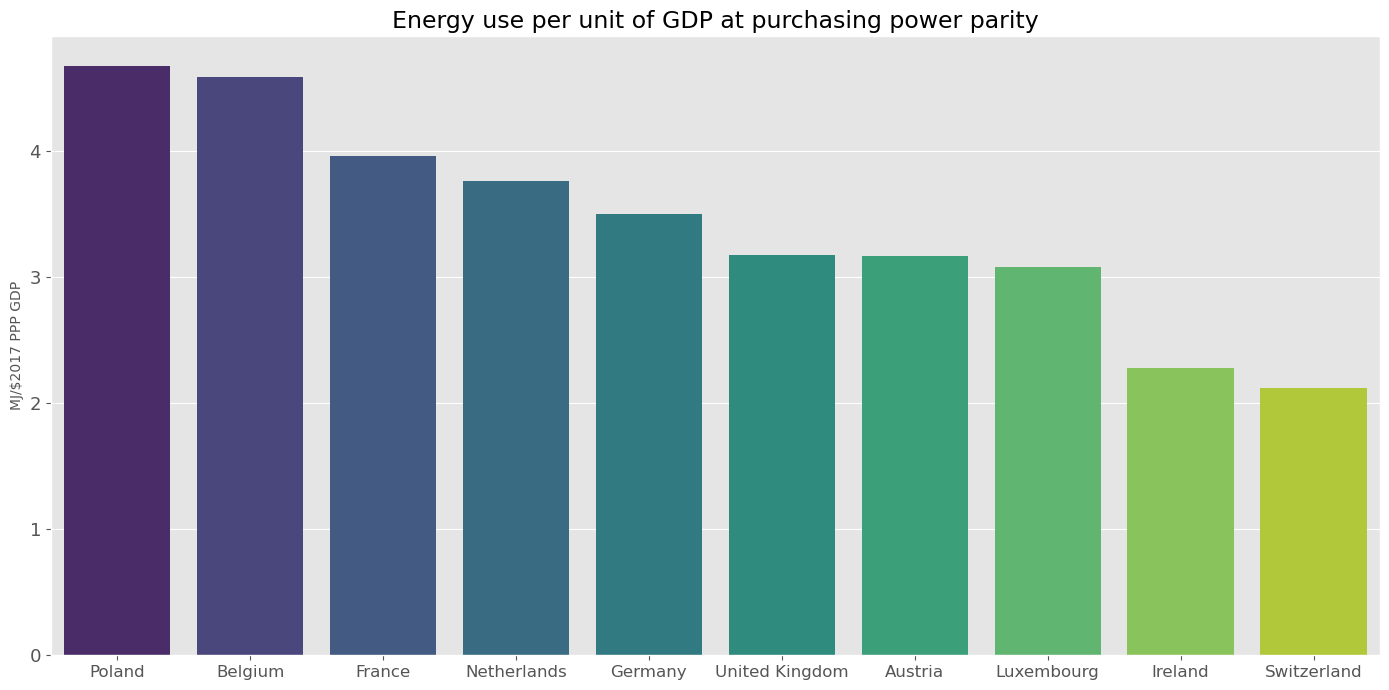

In [97]:
countries_to_plot = west_europe + ['Poland']
plot_data = energy_data_filtered[energy_data_filtered['Entity'].isin(countries_to_plot)]

#plot
fig, ax = plt.subplots(figsize=(14,7))

avg_intensity = plot_data.groupby('Entity')['Energy intensity level of primary energy (MJ/$2017 PPP GDP)'].mean().reset_index()
avg_intensity = avg_intensity.sort_values(by='Energy intensity level of primary energy (MJ/$2017 PPP GDP)',ascending=False)

sns.barplot(data = avg_intensity, x= 'Entity',y='Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
           hue='Entity',palette='viridis',ax=ax)

ax.set_title('Energy use per unit of GDP at purchasing power parity',fontsize=17)
ax.set_xlabel('')
ax.set_ylabel('MJ/$2017 PPP GDP',fontsize=10)
ax.tick_params(axis='y',labelsize=13)
ax.tick_params(axis='x',labelsize=12)

plt.tight_layout()
plt.show()

It turns out that in comparison with the Western Europe it is Poland that is the least energy-efficient country in creating GDP. It uses the most energy to create the same amount of economic output as the rest of the countries. This could be due to reliance on energy-intensive industries or inefficiencies in energy use.


The countries that stand out as the most energy-efficient in creating GDP are Ireland and Switzerland. This could be a result of more advanced technology, energy-saving practices, or a shift to a less energy-intensive service-based economy.

**Primary energy consumption per capita and GDP growth**

Does higher energy consumption equals more economic growth?


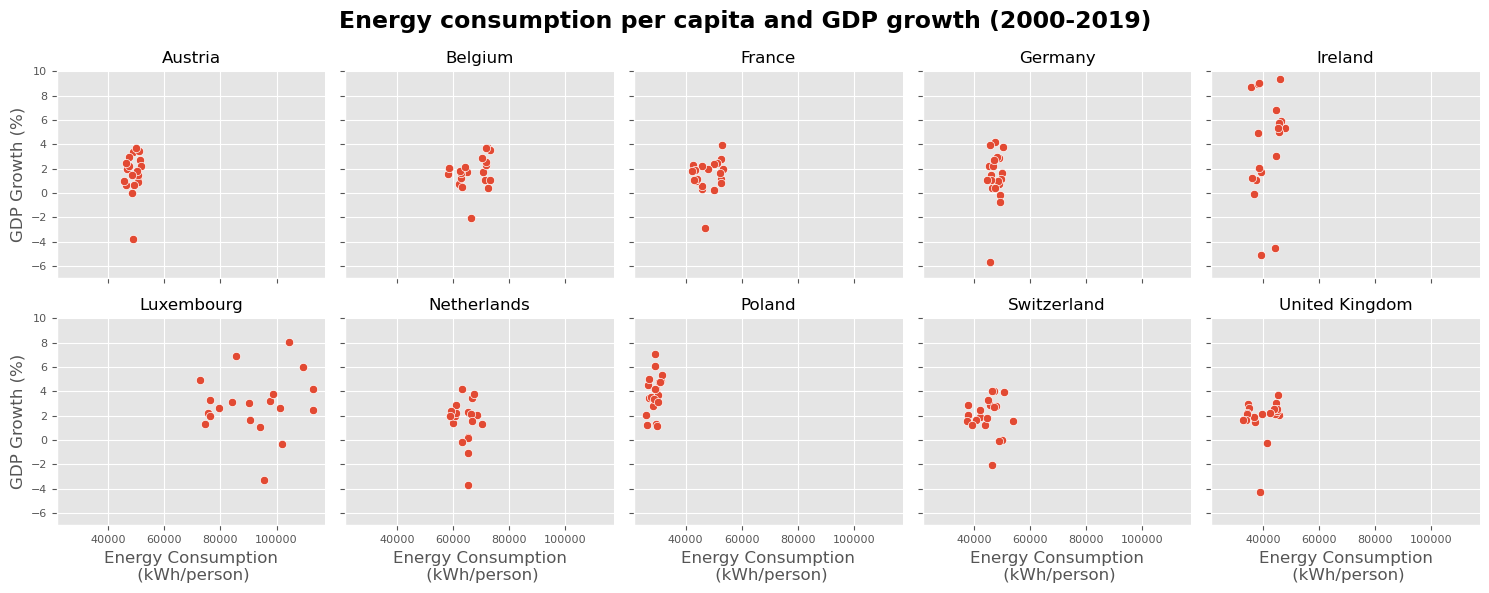

In [98]:
countries_to_plot = west_europe + ['Poland']
plot_data = energy_data_filtered[energy_data_filtered['Entity'].isin(countries_to_plot)]

#plot
g = sns.FacetGrid(plot_data, col='Entity', col_wrap=5, height=3, aspect=1)
g.map(sns.scatterplot, 'Primary energy consumption per capita (kWh/person)', 'gdp_growth')

#titles, labels
g.set_titles("{col_name}")
g.set_axis_labels('Energy Consumption\n (kWh/person)', 'GDP Growth (%)')
g.set(ylim=(-7, 10))

for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.tick_params(axis='both',labelsize=8)


g.fig.suptitle('Energy consumption per capita and GDP growth (2000-2019)',fontsize=17,fontweight='bold')

plt.tight_layout()
plt.show()

The correlation between Energy Consumption and GDP Growth does not occur as these plots demonstrate. That means that even though there might be a higher energy consumption it won't necesarilly cause a bigger economic growth in a country and vice versa.

**Low-carbon electricity use and Country's GDP**

Do countries that produce more low-carbon electricity tend to have higher GDP per capita?

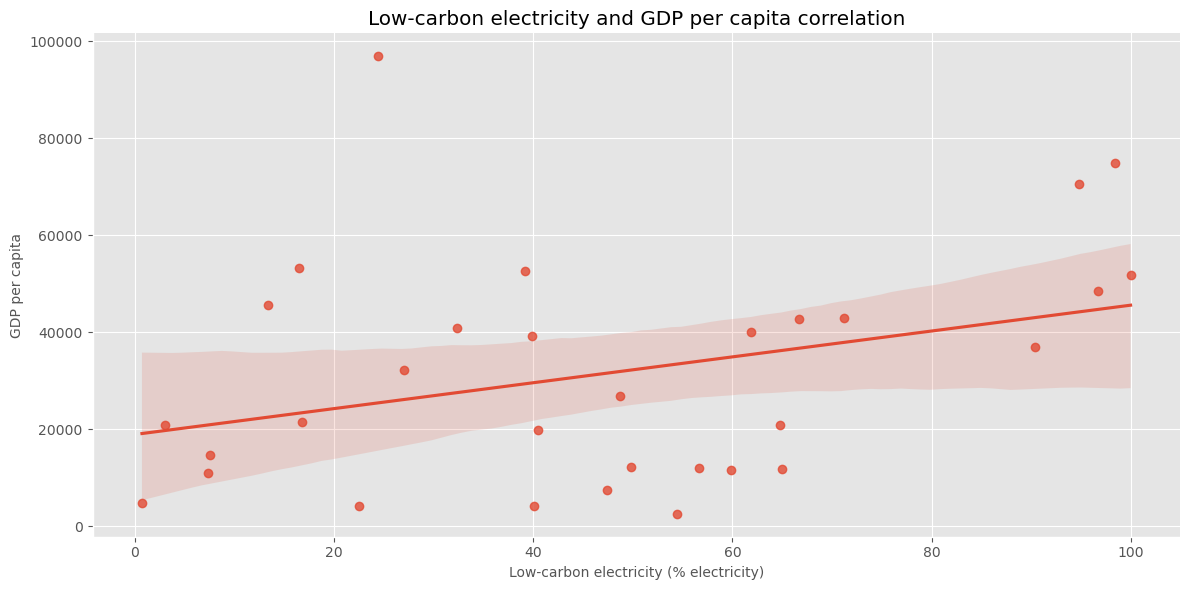

,Low-carbon electricity (% electricity),gdp_per_capita
Low-carbon electricity (% electricity),1.000000,0.338427
gdp_per_capita,0.338427,1.000000


In [99]:
countries_to_plot = energy_data_filtered[energy_data_filtered['Continent'].isin(['Europe'])]['Entity'].unique().tolist()
plot_data = energy_data_filtered[energy_data_filtered['Entity'].isin(countries_to_plot)]

#groupby gdp_per_capita
gdp_groupby = plot_data.groupby('Entity')['gdp_per_capita'].mean().reset_index()

#groupby low carbon electricity
lowcarbon_groupby = plot_data.groupby('Entity')['Low-carbon electricity (% electricity)'].mean().reset_index()

#join both groupby dataframes
merged_plot_data = pd.merge(gdp_groupby,lowcarbon_groupby,on='Entity')
merged_plot_data


#scatterplot
ax = sns.lmplot(data=merged_plot_data,
                  x='Low-carbon electricity (% electricity)',
                  y='gdp_per_capita',
                  height=6, aspect=2)

plt.title('Low-carbon electricity and GDP per capita correlation')
plt.ylabel('GDP per capita',fontsize=10)
plt.xlabel('Low-carbon electricity (% electricity)',fontsize=10)

plt.tight_layout()
plt.show()

corr = merged_plot_data[['Low-carbon electricity (% electricity)','gdp_per_capita']].corr()
corr

We can see a weak positive correlation between *Low-Carbon electricity production and GDP per capita* which means that across Europe, wealthier countries rely on low-carbon energy more than the poorer nationalities. 

Higher GDP per capita often translates to greater financial resources. Wealthier nations may have more funds available to invest in research, development, and deployment of low-carbon technologies, such as wind, solar, hydroelectric and nuclear power.

Also, wealthier country's public may have increased awareness of environmental issues therefore supporting solutions for cleaner energy production which drives the demand for it.

## 2.2 World 

Comparison of energy sector across the continents

**CO2 emissions**

In [100]:
#which countries were dropped in data cleaning

difference = ~energy_data['Entity'].isin(energy_data_filtered['Entity'])
dropped_countries = energy_data[difference]['Entity'].unique()
dropped_countries



array(['Albania', 'Aruba', 'Bahamas', 'Bermuda', 'Bulgaria',
       'Cayman Islands', 'Chile', 'Congo', 'Czechia', 'Djibouti', 'Egypt',
       'Eritrea', 'Gambia', 'Indonesia', 'Kazakhstan', 'Kyrgyzstan',
       'Lebanon', 'Libya', 'Malaysia', 'Nauru', 'New Caledonia',
       'Puerto Rico', 'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Saudi Arabia', 'Slovakia',
       'Somalia', 'Turkey', 'Tuvalu', 'Yemen'], dtype=object)

There weren't any major countries dropped that would significantly affect the results.

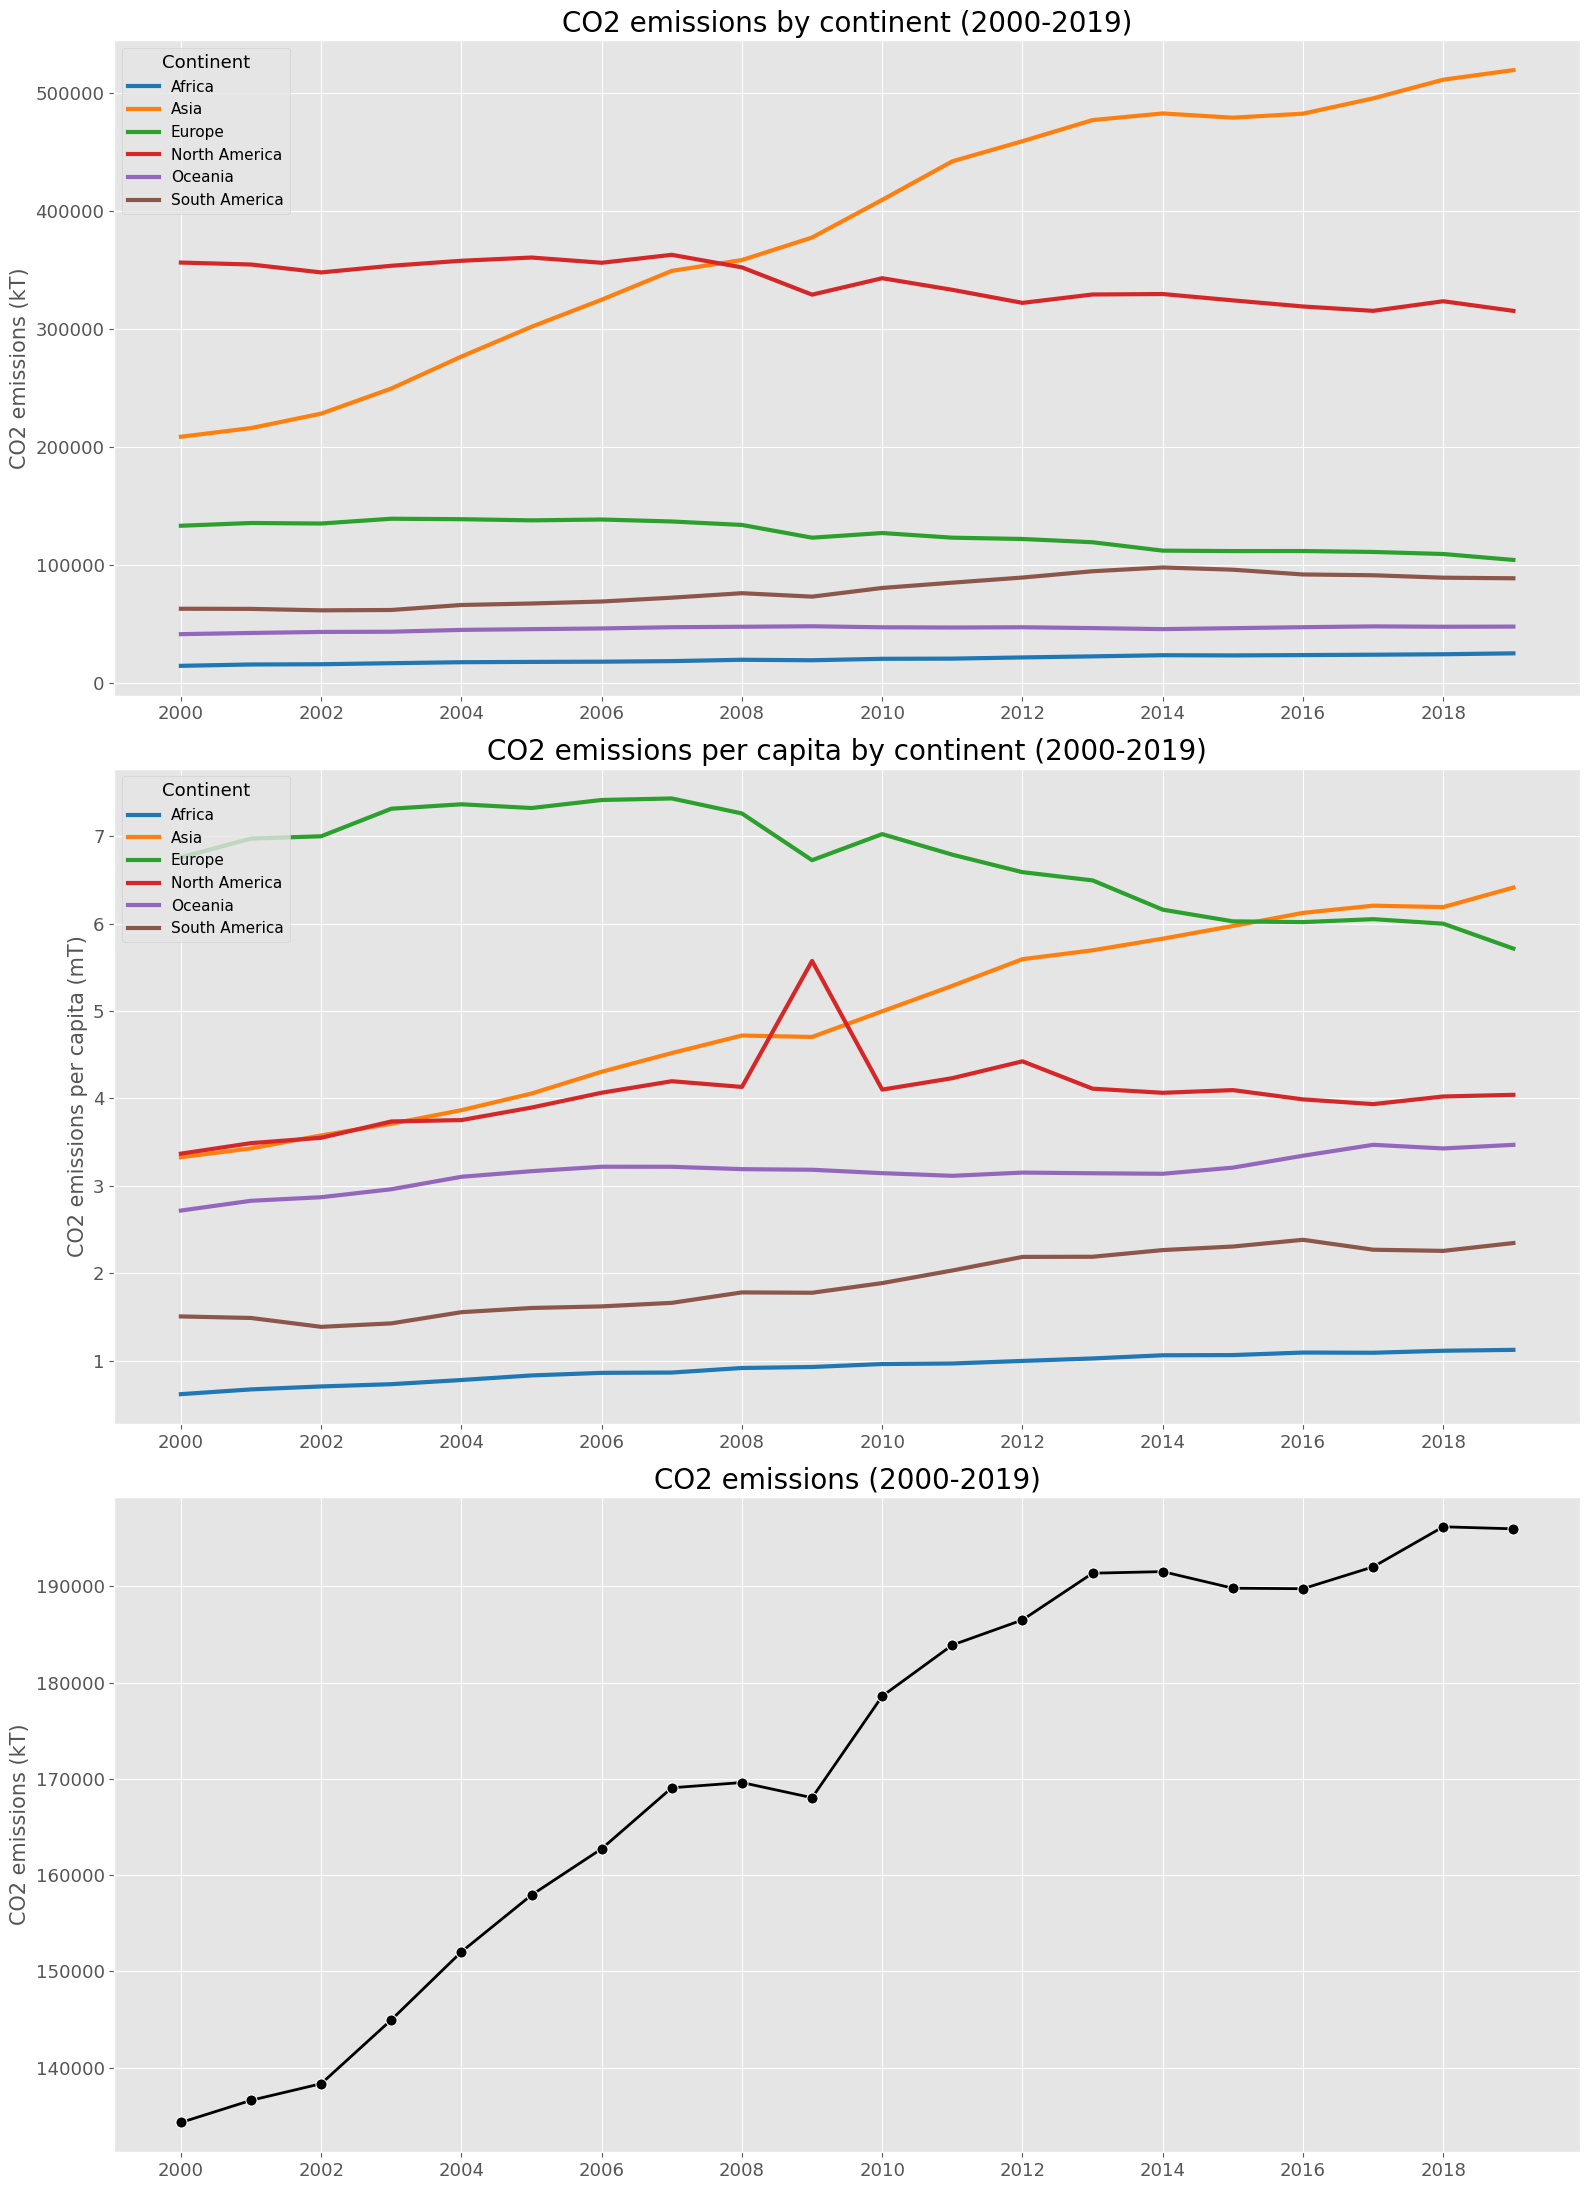

In [101]:
co2_value_groupby = energy_data_filtered.groupby(['Continent','Year'])['Value_co2_emissions_kt_by_country'].mean().reset_index()
co2_percapita_groupby = energy_data_filtered.groupby(['Continent','Year'])['CO2 emissions per capita (mT)'].mean().reset_index()
co2_year_groupby = energy_data_filtered.groupby('Year')['Value_co2_emissions_kt_by_country'].mean().reset_index()

#plot1
fig, ax = plt.subplots(3,1,figsize=(16,22))

sns.lineplot(co2_value_groupby,x='Year',y='Value_co2_emissions_kt_by_country',hue='Continent',palette='tab10',ax=ax[0],lw=3)

ax[0].set_title('CO2 emissions by continent (2000-2019)',fontsize=20)
ax[0].set_xticks(list(range(2000,2020,2)))
ax[0].set_xlabel('')
ax[0].set_ylabel('CO2 emissions (kT)',fontsize=15)
ax[0].tick_params(axis='both',labelsize=13)
ax[0].legend(title='Continent', loc='upper left', title_fontsize='13', fontsize='11')

#plot2
sns.lineplot(co2_percapita_groupby,x='Year',y='CO2 emissions per capita (mT)',hue='Continent',palette='tab10',ax=ax[1],lw=3)

ax[1].set_title('CO2 emissions per capita by continent (2000-2019)',fontsize=20)
ax[1].set_xticks(list(range(2000,2020,2)))
ax[1].set_xlabel('')
ax[1].set_ylabel('CO2 emissions per capita (mT)',fontsize=15)
ax[1].tick_params(axis='both',labelsize=13)
ax[1].legend(title='Continent', loc='upper left', title_fontsize='13', fontsize='11')

#plot3
sns.lineplot(co2_year_groupby,x='Year',y='Value_co2_emissions_kt_by_country',color='black',marker='o',ax=ax[2],lw=2,markersize=8)

ax[2].set_title('CO2 emissions (2000-2019)',fontsize=20)
ax[2].set_xticks(list(range(2000,2020,2)))
ax[2].set_xlabel('')
ax[2].set_ylabel('CO2 emissions (kT)',fontsize=15)
ax[2].tick_params(axis='both',labelsize=13)


plt.tight_layout()
plt.show()


For the last 20 years we have seen CO2 emissions annualy increasing. Asia is a continent were CO2 emissions have been consantly rising and in 2019 it was the most CO2 emmiting region in both general emissions and emmisions per capita, even though it has the largest population in the world.

The CO2 emissions of the rest of the regions remained the same or decreased with North America having decreased the most in overall value and Europe in value per capita.

It seems that Asia that is contributing the most to a stedy increase in CO2 emissions.

**Change in energy share**

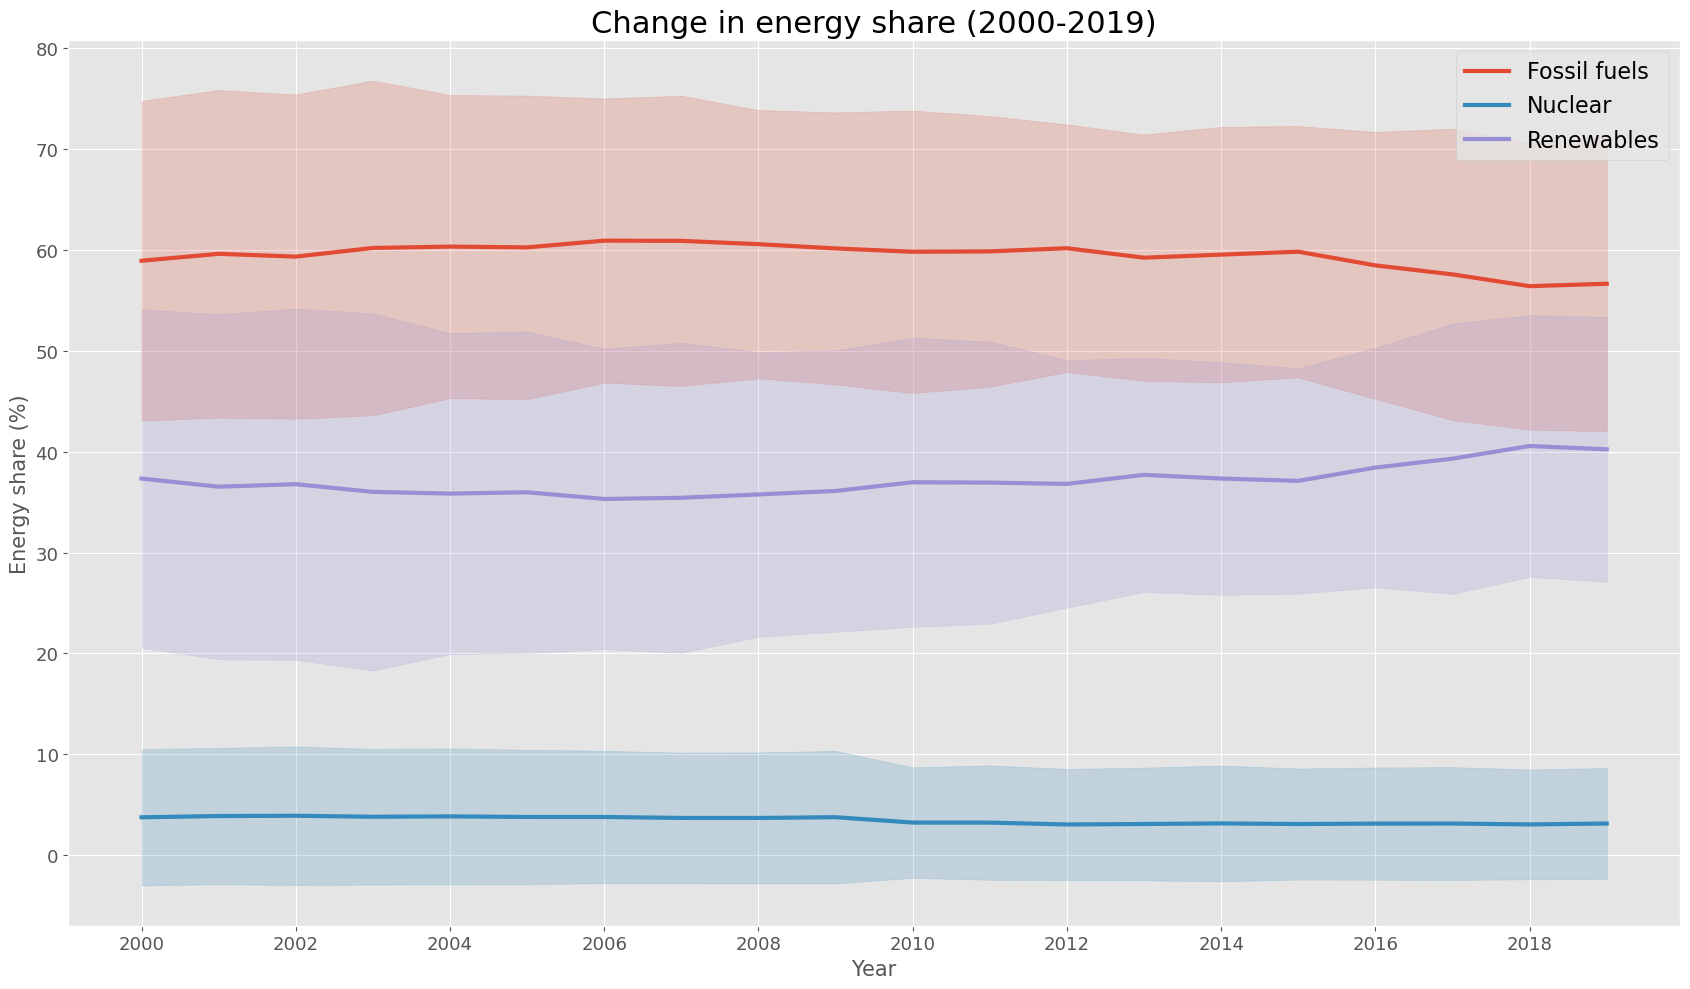

In [102]:
fossil_groupby = energy_data_filtered.groupby(['Continent','Year'])['Fossil fuels (%)'].mean().reset_index()
nuclear_groupby = energy_data_filtered.groupby(['Continent','Year'])['Nuclear (%)'].mean().reset_index()
renewables_groupby = energy_data_filtered.groupby(['Continent','Year'])['Renewables (%)'].mean().reset_index()
#plot
fig, ax = plt.subplots(figsize=(17,10))

sns.lineplot(data=fossil_groupby, x='Year',y='Fossil fuels (%)',lw=3,estimator=np.mean, errorbar='sd',label='Fossil fuels',ax=ax)
sns.lineplot(data=nuclear_groupby, x='Year',y='Nuclear (%)',lw=3,estimator=np.mean, errorbar='sd',label='Nuclear',ax=ax)
sns.lineplot(data=renewables_groupby, x='Year',y='Renewables (%)',lw=3,estimator=np.mean, errorbar='sd',label='Renewables',ax=ax)

plt.legend(fontsize=16)
plt.title('Change in energy share (2000-2019)',fontsize=22)
plt.ylabel('Energy share (%)',fontsize=15)
plt.xlabel('Year',fontsize=15)
plt.xticks(range(2000,2020,2))
plt.tick_params(axis='both',labelsize=13)

plt.tight_layout()
plt.show()

There is a very slight increase in renewable energy share in the 2000-2019 period and a very slight decrease in fossil fuels.

Nuclear power stays basically on the same level since 2000.

**Population Density vs Access to electricity**

Does population density affect access to electricity?

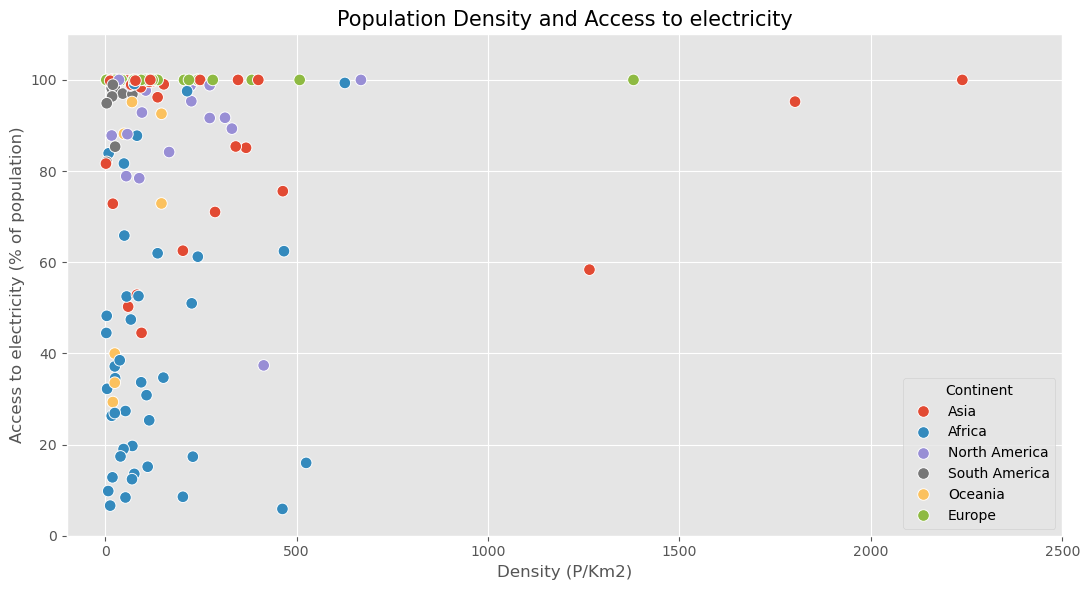

,Density (P/Km2),Access to electricity (% of population)
Density (P/Km2),1.000000,0.100238
Access to electricity (% of population),0.100238,1.000000


In [103]:
density_groupby = energy_data_filtered.groupby(['Entity','Continent'])[['Density (P/Km2)','Access to electricity (% of population)']].mean().reset_index()

#plot

fig, ax = plt.subplots(figsize=(11,6))

sns.scatterplot(data = density_groupby,x='Density (P/Km2)',y='Access to electricity (% of population)',hue='Continent',s=70,ax=ax)

plt.ylim(0,110)
plt.xlim(-100,2500)
plt.title('Population Density and Access to electricity',fontsize=15)


plt.tight_layout()
plt.show()

corr = density_groupby[['Density (P/Km2)','Access to electricity (% of population)']].corr()
corr

There is a very weak, negligible correlation between Population Density and Access to electricity. Which means that it doesn't matter if a region is densly populated for it to have an access to electricity.

Also we can see that Africa is a region with the most countries where more than half of the people don't have an access to electricity. The only continent where every person has access to electricity is Europe.


**Renewable energy adoption over time**

How has the adoption of renewable energy sources evolved globally or in specific regions?

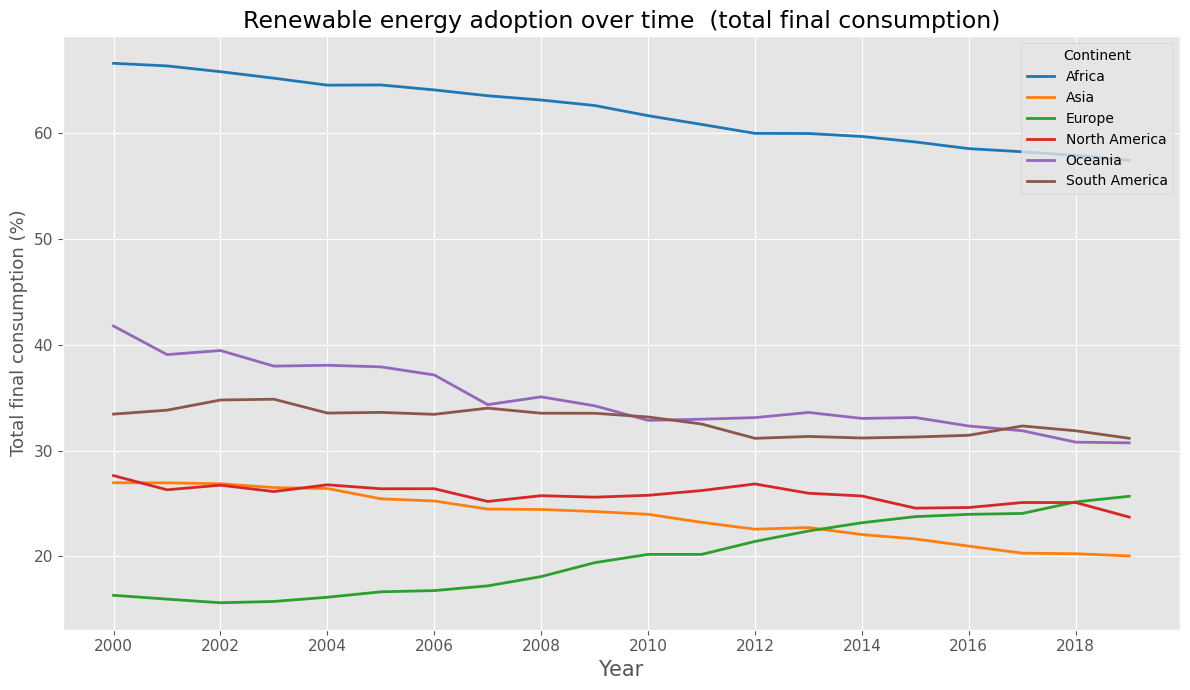

In [104]:
renewable_consumption_groupby = energy_data_filtered.groupby(['Continent','Year'])['Renewable energy share in the total final energy consumption (%)'].mean().reset_index()
renewable_consumption_groupby

#plot

fig, ax = plt.subplots(figsize=(12,7))

sns.lineplot(data =renewable_consumption_groupby,x='Year',y='Renewable energy share in the total final energy consumption (%)',
            hue = 'Continent',lw=2,palette='tab10',ax=ax)

plt.legend(title='Continent',fontsize=10,loc='upper right')
plt.title('Renewable energy adoption over time  (total final consumption)',fontsize=17)
plt.ylabel('Total final consumption (%)',fontsize=13)
plt.xlabel('Year',fontsize=15)
plt.xticks(range(2000,2020,2))
plt.tick_params(axis='both',labelsize=11)


plt.tight_layout()
plt.show()

Each region have seen a decrease in total final consumption of renewable energy apart from Europe which has increased over 10%.

Highest total final consumption of renewable energy is in Africa, and the least is in Asia. It is probably due to it increasing fossil fuel production over the 20 years period.

**Energy consumption per capita over time**

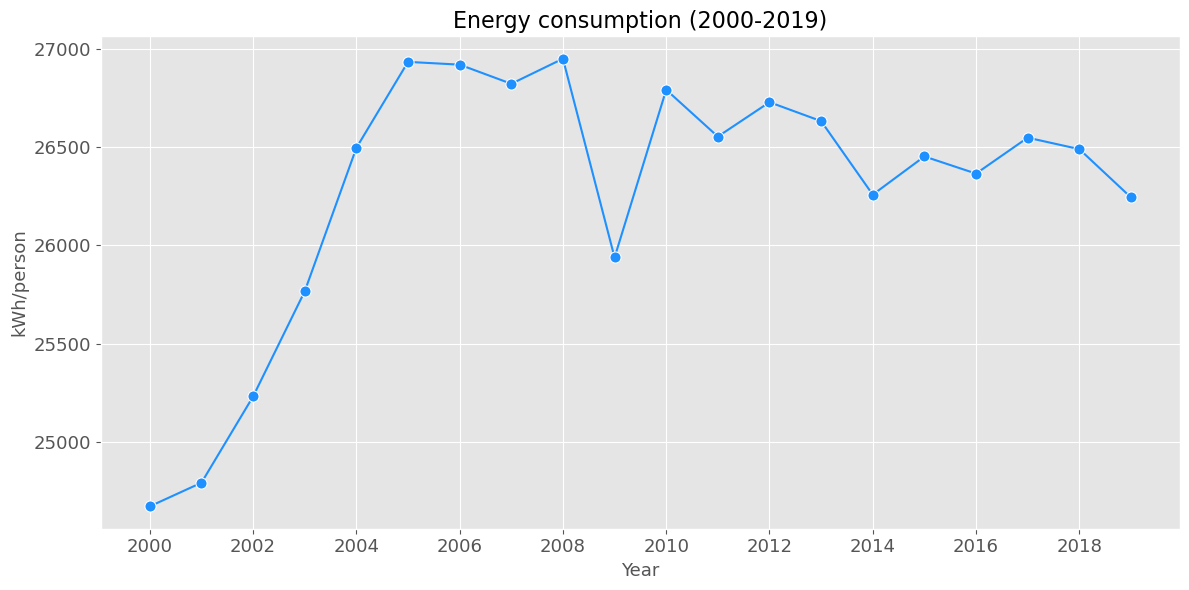

In [105]:
energy_consumption_groupby = energy_data_filtered.groupby('Year')['Primary energy consumption per capita (kWh/person)'].mean().reset_index()
energy_consumption_groupby

fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(energy_consumption_groupby,x='Year',y='Primary energy consumption per capita (kWh/person)',
            color='dodgerblue',marker='o',ax=ax,lw=1.5,markersize=8)

ax.set_title('Energy consumption (2000-2019)',fontsize=16)
ax.set_xticks(list(range(2000,2020,2)))
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('kWh/person',fontsize=13)
ax.tick_params(axis='both',labelsize=13)

plt.tight_layout()
plt.show()


In the years 2000-2008 there has been a sharp increase in energy consumption per capita. After that there's been a steady decrease.

This plot shows that energy consumption per capita is tend to decrease even more in the future which may be due to increased energy efficiency, a shift to less energy demanding industries and advancements in technology.